In [1]:
import asimov_database as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pr = ad.ParquetReader()



class Causality:
    def __init__(self, dol, wdo, date):
        self.date = date
        self.dol = dol
        self.wdo = wdo
    
    def _files(self):

        #Carrega e Trata os arquivos
        level_data = pr.get_parquet(self.dol, self.date, "level-book")
        events = pr.get_parquet(self.dol, self.date, "events")["incremental"].read().to_pandas()
        snap = pr.get_parquet(self.dol, self.date, "events")["snapshot"].read().to_pandas()

        level_data_wdo = pr.get_parquet(self.wdo, self.date, "level-book")
        events_wdo = pr.get_parquet(self.wdo, self.date, "events")["incremental"].read().to_pandas()
        snap_wdo = pr.get_parquet(self.wdo, self.date, "events")["snapshot"].read().to_pandas()

        bid_price = level_data["bid_price"].read().to_pandas()
        bid_quantity = level_data["bid_quantity"].read().to_pandas()
        bid_inc_code = level_data["bid_inc_code"].read().to_pandas()

        ask_price = level_data["ask_price"].read().to_pandas()
        ask_quantity = level_data["ask_quantity"].read().to_pandas()
        ask_inc_code = level_data["ask_inc_code"].read().to_pandas()

        bid_price_wdo= level_data_wdo["bid_price"].read().to_pandas()
        bid_quantity_wdo = level_data_wdo["bid_quantity"].read().to_pandas()
        bid_inc_code_wdo = level_data_wdo["bid_inc_code"].read().to_pandas()

        ask_price_wdo = level_data_wdo["ask_price"].read().to_pandas()
        ask_quantity_wdo = level_data_wdo["ask_quantity"].read().to_pandas()
        ask_inc_code_wdo = level_data_wdo["ask_inc_code"].read().to_pandas()

        bid_wdo = bid_price_wdo[["bid_0"]].copy()
        bid_quantity_wdo.columns = ["bid_quantity_wdo_{}".format(i) for i in range(bid_quantity_wdo.shape[1])]
        bid_wdo["bid_quantity_wdo_0"] = bid_quantity_wdo["bid_quantity_wdo_0"]
        bid_wdo["i_bid_wdo"] = bid_inc_code_wdo[0]#.apply(lambda x: "B_" + str(x))
        bid_wdo.rename({'bid_0' : 'bid_wdo_0'}, axis = 1, inplace = True )

        bid = bid_price[["bid_0"]].copy()
        bid_quantity.columns = ["bid_quantity_{}".format(i) for i in range(bid_quantity.shape[1])]
        bid["bid_quantity_0"] = bid_quantity["bid_quantity_0"]
        bid["i_bid"] = bid_inc_code[0]

        ask = ask_price[["ask_0"]].copy()
        ask_quantity.columns = ["ask_quantity_{}".format(i) for i in range(ask_quantity.shape[1])]
        ask["ask_quantity_0"] = ask_quantity["ask_quantity_0"]
        ask["i_ask"] =ask_inc_code[0]#.apply(lambda x: "A_" + str(x))

        ask_wdo = ask_price_wdo[["ask_0"]].copy()

        ask_wdo.rename({'ask_0':'ask_wdo_0'}, axis = 1, inplace= True)

        ask_quantity_wdo.columns = ["ask_quantity_wdo_{}".format(i) for i in range(ask_quantity_wdo.shape[1])]
        ask_wdo["ask_quantity_wdo_0"] = ask_quantity_wdo["ask_quantity_wdo_0"]
        ask_wdo["i_ask_wdo"] =ask_inc_code_wdo[0]

        events.reset_index(inplace=True)
        events_wdo.reset_index(inplace=True)

        #Procura por atualizações provenientes da bolsa e retira da versão final
        valor_dol = np.setdiff1d(events['i'].values, bid_inc_code[0].values)
        valor_dol   

        retira_dol = np.setdiff1d(valor_dol,ask_inc_code[0].values)
        retira_dol

        valor_wdo_ask = np.setdiff1d(events_wdo['i'].values, bid_inc_code_wdo[0].values)
        valor_wdo_ask

        retira_wdo_ask = np.setdiff1d(valor_wdo_ask,ask_inc_code_wdo[0].values)
        retira_wdo_ask

        valor_wdo_bid = np.setdiff1d(events_wdo['i'].values, ask_inc_code_wdo[0].values)
        valor_wdo_bid

        retira_wdo_bid = np.setdiff1d(valor_wdo_bid, bid_inc_code_wdo[0].values)
        retira_wdo_bid

        if len(retira_dol) != 0:
            for i in retira_dol:
                events = events[events['i'] != i]


        if len(retira_wdo_bid) != 0:
            for i in retira_wdo_bid:
                events_wdo = events_wdo[events_wdo['i'] != i]
        
        # Busca os arquivos de eventos
        self.events = events
        self.events_wdo = events_wdo


        #Cria os arquivos de bid e ask
        bid["msg_seq_num"] = events[events["side"] != "A"]["msg_seq_num"].values
        bid['event_type'] =  events[events["side"] != "A"]["event_type"].values
        ask["msg_seq_num"] = events[events["side"] != "B"]["msg_seq_num"].values
        ask["event_type"] = events[events["side"] != "B"]["event_type"].values
        
        
        bid_wdo["msg_seq_num"] = events_wdo[events_wdo["side"] != "A"]["msg_seq_num"].values
        ask_wdo["msg_seq_num"] = events_wdo[events_wdo["side"] != "B"]["msg_seq_num"].values
        bid_wdo["event_type"] = events_wdo[events_wdo["side"] != "A"]["event_type"].values
        ask_wdo["event_type"] = events_wdo[events_wdo["side"] != "B"]["event_type"].values
        
        bid_wdo["i"] = events_wdo[events_wdo["side"] != "A"]["i"].values
        ask_wdo["i"] = events_wdo[events_wdo["side"] != "B"]["i"].values
        bid["i"] =  events[events["side"] != "A"]["i"].values
        ask["i"] = events[events["side"] != "B"]["i"].values
        
        
        ask_wdo['side'] = 'A'
        ask['side'] = 'A'
        
        bid_wdo['side'] = 'B'
        bid['side'] = 'B'

        #Cria a versao final ja preenchendo os espacos vazios com os correspondentes valores
        df = pd.concat([ask, bid]).sort_values(by='i', kind = 'mergesort').reset_index()
        dl = pd.concat([ask_wdo, bid_wdo]).sort_values(by='i', kind = 'mergesort').reset_index()

        df['symbol'] = 'DOL'
        dl['symbol'] = 'WDO'
        df.ffill(inplace=True)
        df.dropna(inplace=True)
        dl.ffill(inplace=True)
        dl.dropna(inplace=True)
        
        total = pd.concat([df, dl]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()

        total.ffill(inplace=True)
        total.dropna(inplace=True)

        total_ = total[['index', 'event_type', 'side',  'symbol', 'msg_seq_num', 'ask_0', 'ask_quantity_0', 'bid_0', 'bid_quantity_0', 'ask_wdo_0', 'ask_quantity_wdo_0', 'bid_wdo_0', 'bid_quantity_wdo_0']][ (total['ask_0'] != 0) & (total['bid_0'] != 0)]

        total_['spread_dol'] = total['ask_0'] - total['bid_0']
        total_['spread_wdo'] = total['ask_wdo_0'] - total['bid_wdo_0']
                
        
        #Procura pelo primeiro momento de mercado estável
        begin = np.where( (total_['spread_wdo'] == 0.5) & (total_['spread_dol'] == 0.5) & (total_['ask_0'] == total_['ask_wdo_0']) & (total_['bid_0'] == total_['bid_wdo_0']))[0][0]

        total_.rename({'index' : 'timestamp'}, axis = 1, inplace = True)
             
        # Inicia análise no primeiro momento de estabilidade
        slice_ = total_.loc[begin:]
               
        #Calcula mid price
        slice_['mid_price'] = (slice_['ask_0'] + slice_['bid_0'])/2.0
        slice_['mid_price_wdo'] = (slice_['ask_wdo_0'] + slice_['bid_wdo_0'])/2.0
        
#         self.total__= slice_


        #Filtras msg_seq_number e observa apenas o ultimo evento ocorrido
        slice_['repeat'] = False
        slice_['repeat'][slice_['msg_seq_num'] != slice_['msg_seq_num'].shift(-1)] = True
        slice_  = slice_[slice_['repeat']]
        self.total__= slice_
        slice_ = slice_.drop(['repeat', 'event_type', 'symbol', 'side', 'i'], axis =1).reset_index()

        #Procura primeiro instance de spread aberto
        index_ = np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )[0]

        #Procura as posicoes no vetor anterior, onde os momento de spread aberto nao sao consecutivos
        position = np.where(np.diff(np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )) != 1)[1] +1

        #Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de instabilidade
        A = []
        for i in position:
            A.append(index_[i])

            
            
        ############################################################
#         #Cria um dict com o evento de distorçao e o evento anterior
#         frame = pd.DataFrame()
#         dict_ = {}
#         j=0
#         for i in A:
#             dict_[j] = frame.append(slice_.loc[i-1:i])
#             j+=1


#         for i in dict_.keys():
#             dict_[i] = dict_[i].diff()

        #########################################################

        # distortion = pd.concat(dict_).reset_index()

        # mover = distortion.dropna()[['ask_0', 'bid_0', 'ask_wdo_0', 'bid_wdo_0' ]]
        # mover[mover['ask_0'] != 0].count()
        # mover[mover['bid_0'] != 0].count()
        # mover[mover['ask_wdo_0'] != 0].count()
        # mover[mover['bid_wdo_0'] != 0].count()

        #Cria um dict com o evento de distorçao e 300 eventos posteriores e o evento anterior
        frame_next = pd.DataFrame()
        dict_next = {}
        j=0
        for i in A:
            dict_next[j] = frame_next.append(slice_.loc[i-1:i+300])
            j+=1

        dict_next_aux = {}
        for i in dict_next.keys():
            dict_next_aux[i] = dict_next[i].diff()

        for i in dict_next.keys():
            dict_next_aux[i]['spread_dol'] = dict_next[i]['spread_dol']
            dict_next_aux[i]['spread_wdo'] = dict_next[i]['spread_wdo']
            dict_next_aux[i]['msg_seq_num'] = dict_next[i]['msg_seq_num'] 

        return dict_next_aux

        # distortion_next = pd.concat(dict_next_aux).reset_index()

    # Cria novas colunas do dataframe com valores que correspondem ao trend do movimento
    def func(self, dataframe):
        dataframe['movement_dol'] = [-1 if x < 0 else 0 if x == 0 else 1 for x in dataframe['mid_price']]
        dataframe['movement_wdo'] = [-1 if x < 0 else 0 if x == 0 else 1 for x in dataframe['mid_price_wdo']]
#         # dataframe = self._files()
#         dataframe.loc[dataframe['mid_price'] < 0, 'movement_dol'] = -1
#         dataframe.loc[dataframe['mid_price']  == 0, 'movement_dol'] = 0
#         dataframe.loc[dataframe['mid_price']  > 0, 'movement_dol'] = 1
#         dataframe.loc[dataframe['mid_price_wdo'] < 0, 'movement_wdo'] = -1
#         dataframe.loc[dataframe['mid_price_wdo']  == 0, 'movement_wdo'] = 0
#         dataframe.loc[dataframe['mid_price_wdo']  > 0, 'movement_wdo'] = 1
        return dataframe 

    def organiza(self):

        dict_next_aux = self._files()
        
        # Aplica a funcao anterior ao dataframe
        df = {}
        for i in dict_next_aux.keys():
            df[i] = self.func(dict_next_aux[i])[['movement_dol', 'movement_wdo',  'mid_price', 'mid_price_wdo', 'msg_seq_num']].dropna()
        
#         for i in dict_next_aux.keys():
#             df[i].dropna(inplace = True)

        # Procura no dict de dataframes o primeiro momento onde todos os comportamentos ocorrem no evento de distorçao 
        for i in df.keys():
            if (len(np.where(df[i]['movement_wdo'] == 1)[0]) != 0)  and (len(np.where(df[i]['movement_wdo'] == -1)[0]) != 0) and (len(np.where(df[i]['movement_dol'] == 1)[0]) != 0) and (len(np.where(df[i]['movement_dol'] == -1)[0]) != 0):
                break
        
        a = i
        return df, a

    def operacoes(self): 
        
        self.A,self.B,self.C,self.D,self.E,self.F,self.G,self.H = ([] for i in range(8))
        df, begin_ = self.organiza()
        self.aux_dol = 0
        self.aux_wdo = 0
        self.follow_up  = 0
        self.not_follow_up = 0
        self.follow_down = 0
        self.not_follow_down = 0
        self.follow_up_wdo  = 0
        self.not_follow_up_wdo = 0
        self.follow_down_wdo = 0
        self.not_follow_down_wdo = 0
#         self.cum_sum_wdo_WDO = {}
#         self.cum_sum_dol_WDO = {}
#         self.cum_sum_wdo_DOL = {}
#         self.cum_sum_dol_DOL = {}

        ###Inicia do primeiro momento nao vazio, ate o final do dict
        for i in range(begin_,max(df.keys())):
#             self.cum_sum_wdo_WDO[i] = {}
#             self.cum_sum_dol_WDO[i] = {}
#             self.cum_sum_wdo_DOL[i] = {}
#             self.cum_sum_dol_DOL[i] = {}
            df[i].reset_index(inplace=True) #Reinicia index para fazer slice
            for j in range(max(len(np.where(df[i]['movement_wdo'] == 1)[0]), len(np.where(df[i]['movement_wdo'] == -1)[0]), len(np.where(df[i]['movement_dol'] == 1)[0]), len(np.where(df[i]['movement_dol'] == -1)[0]))):
                a_ = np.where(df[i]['movement_wdo'] == 1)[0]
                b_ = np.where(df[i]['movement_wdo'] == -1)[0]
                c_ = np.where(df[i]['movement_dol'] == 1)[0]
                d_ = np.where(df[i]['movement_dol'] == -1)[0]
                if (len(a_) != 0)  and (len(b_) != 0) and (len(c_) != 0) and (len(d_) != 0):
                    ## Checa para ver se o WDO foi responsavel pelo primeiro movimento 
                    if min(a_[0], b_[0]) <  min(c_[0], d_[0]):
                        self.aux_wdo+=1
                        ## Checa para ver se o primeiro movimento foi up ou down 
                        if a_[0] < b_[0]:
                            steps = b_[0] # Determina o tamanho do slice no DataFrame
                            if c_[0] < steps:                                
                                self.A.append(df[i]['msg_seq_num'].values[a_[0]])
                                self.follow_up_wdo +=1
#                                 self.cum_sum_wdo_WDO[i][j] = df[i]['mid_price_wdo'].loc[a_[0]:steps-1].sum()
#                                 self.cum_sum_dol_WDO[i][j] = df[i]['mid_price'].loc[c_[0]:steps-1].sum()
                            else:
                                self.B.append(df[i]['msg_seq_num'].values[a_[0]])
                                self.not_follow_up_wdo +=1  
                        else:
                            steps = a_[0]
                            if d_[0] < steps:
                                self.C.append(df[i]['msg_seq_num'].values[b_[0]])
                                self.follow_down_wdo +=1
#                                 self.cum_sum_wdo_WDO[i][j] = df[i]['mid_price_wdo'].loc[b_[0]:steps-1].sum()
#                                 self.cum_sum_dol_WDO[i][j] = df[i]['mid_price'].loc[d_[0]:steps-1].sum()
                            else:
                                self.D.append(df[i]['msg_seq_num'].values[b_[0]])
                                self.not_follow_down_wdo +=1
                    else:
                        self.aux_dol+=1
                        if c_[0] < d_[0]:
                            steps = d_[0]
                            if a_[0] < steps:
                                self.E.append(df[i]['msg_seq_num'].values[c_[0]])
                                self.follow_up +=1
#                                 self.cum_sum_wdo_DOL[i][j] = df[i]['mid_price_wdo'].loc[a_[0]:steps-1].sum()
#                                 self.cum_sum_dol_DOL[i][j] = df[i]['mid_price'].loc[c_[0]:steps-1].sum()
                            else:
                                self.F.append(df[i]['msg_seq_num'].values[c_[0]])
                                self.not_follow_up +=1
                        else:
                            steps = c_[0]
                            if b_[0] < steps:
                                self.G.append(df[i]['msg_seq_num'].values[d_[0]])
                                self.follow_down +=1
#                                 self.cum_sum_wdo_DOL[i][j] = df[i]['mid_price_wdo'].loc[b_[0]:steps-1].sum()
#                                 self.cum_sum_dol_DOL[i][j] = df[i]['mid_price'].loc[d_[0]:steps-1].sum()
                            else:
                                self.H.append(df[i]['msg_seq_num'].values[d_[0]])
                                self.not_follow_down +=1

                df[i] = df[i].loc[steps:]
#                 df[i].dropna(inplace = True)





In [3]:
def plot():
    N = 2
    DOL_Following = (e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo),  e.follow_up/(e.follow_up+e.not_follow_up))
    WDO_Following = (e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_down/(e.follow_down+e.not_follow_down))

    DOL_FollowingStd = np.std([e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo)])

    WDO_FollowingStd = np.std([ e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down)])
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.bar(ind, DOL_Following, width,yerr=DOL_FollowingStd )
    p2 = plt.bar(ind, WDO_Following, width,
                 bottom=DOL_Following, yerr=WDO_FollowingStd)

    plt.ylabel('Percentage')
    plt.title('Movement Trend')
    plt.xticks(ind, ('DOL_Following', 'WDO_Following'))
    # plt.yticks(np.arange(0, 81, 10))
    plt.legend((p1[0], p2[0]), ('Up', 'Down'))

    plt.show()

In [3]:
e = Causality("DOLG20", "WDOG20", "2020-01-06")

# e.operacoes()


In [4]:
# @LProfiler.do_profile(follow=[e.operacoes, e._files,  e.organiza ])
# def _iter(e):
#     e.operacoes()
# _iter(e)

In [5]:
dh = {}

# DATA PROCESSING

In [7]:
begin = np.where( (e.total__['spread_wdo'] == 0.5) & (e.total__['spread_dol'] == 0.5) & (e.total__['ask_0'] == e.total__['ask_wdo_0']) & (e.total__['bid_0'] == e.total__['bid_wdo_0']))[0][0]

begin

15

In [8]:
total__ = e.total__.reset_index()

In [9]:
total_ = total__.loc[begin:].reset_index().drop({'level_0', 'index'}, axis = 1)

In [10]:
#Check if there are any duplicats in a given column
boolean = total_['msg_seq_num'].duplicated().any() 
boolean

False

In [11]:
total_

,timestamp,event_type,side,symbol,msg_seq_num,ask_0,ask_quantity_0,bid_0,bid_quantity_0,ask_wdo_0,ask_quantity_wdo_0,bid_wdo_0,bid_quantity_wdo_0,spread_dol,spread_wdo,mid_price,mid_price_wdo,repeat
0,2020-01-06 12:00:50.186000+00:00,INSERT,B,WDO,21223,4065.0,5.0,4064.5,5.0,4065.0,22.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
1,2020-01-06 12:00:50.186000+00:00,CHANGE,A,WDO,21224,4065.0,5.0,4064.5,5.0,4065.0,17.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
2,2020-01-06 12:00:50.186000+00:00,CHANGE,A,WDO,21225,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
3,2020-01-06 12:00:50.186000+00:00,DELETE,B,WDO,21226,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
4,2020-01-06 12:00:50.186000+00:00,DELETE,B,WDO,21227,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.0,118.0,0.5,1.0,4064.75,4064.50,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087745,2020-01-06 21:14:59.807000+00:00,DELETE,A,WDO,3347334,4068.0,10.0,4067.0,15.0,4067.5,14.0,4066.5,15.0,1.0,1.0,4067.50,4067.00,True
3087746,2020-01-06 21:14:59.847000+00:00,DELETE,B,WDO,3347335,4068.0,10.0,4067.0,15.0,4067.5,14.0,4066.5,15.0,1.0,1.0,4067.50,4067.00,True
3087747,2020-01-06 21:14:59.907000+00:00,INSERT,A,DOL,3347336,4068.0,10.0,4067.0,15.0,4067.5,14.0,4066.5,15.0,1.0,1.0,4067.50,4067.00,True
3087748,2020-01-06 21:15:00.013000+00:00,STATUS,B,DOL,3347337,4068.0,10.0,4067.0,15.0,4067.5,14.0,4066.5,15.0,1.0,1.0,4067.50,4067.00,True


In [12]:
slice_ = total_

index_ = np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )[0]

#Procura as posicoes no vetor anterior, onde os momento de spread aberto nao sao consecutivos
position_open = np.where(np.diff(np.where( (slice_['spread_dol'] != 0.5) | (slice_['spread_wdo'] != 0.5) )) != 1)[1] +1

#Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de instabilidade
A = []
for i in position_open:
    A.append(index_[i])

In [12]:
# A

# Tests of trend following

## Dia 11/11/2019


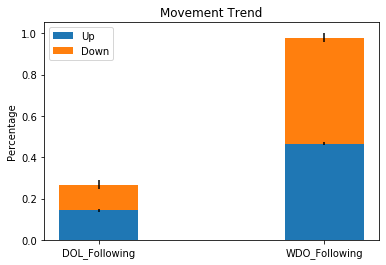

Dia 02/01 
 Porcetagem DOL seguiu WDO em up : 0.1428891377379619, Porcetagem DOL seguiu WDO em down: 0.12532894736842104,
 Porcetagem WDO seguiu DOL em up: 0.4664793255720594, Porcetagem WDO seguiu DOL em down: 0.5131334022750775
 Instabilidade causada por WDO: 0.647719524886066, por DOL: 0.35228047511393407  


In [121]:
plot()
print('Dia 11/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

In [117]:
Values_ = [e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol)]
dh[0] =  pd.DataFrame(Values_).T.rename({0: 'DOL_FOL_UP', 1:'DOL_FOL_DOWN', 2: 'WDO_FOL_UP', 3: 'WDO_FOL_DOWN', 4: 'WDO_BEGAN', 5: 'DOL_BEGAN' }, axis = 1)


## Dia 13/11/2019

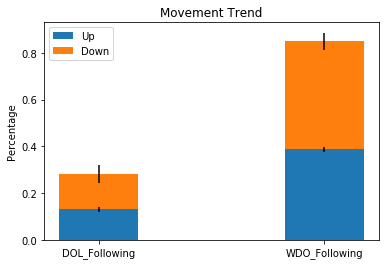

 Dia 13/01 
 Porcetagem DOL seguiu WDO em up : 0.1310754226957121, Porcetagem DOL seguiu WDO em down: 0.15050510230244604,
 Porcetagem WDO seguiu DOL em up: 0.3874148296593186, Porcetagem WDO seguiu DOL em down: 0.46113367799113736
 Instabilidade causada por WDO: 0.6220997162545602, por DOL: 0.3779002837454398  


In [131]:
plot()
print(' Dia 13/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

In [133]:
Values_ = [e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol)]
dh[1] =  pd.DataFrame(Values_).T.rename({0: 'DOL_FOL_UP', 1:'DOL_FOL_DOWN', 2: 'WDO_FOL_UP', 3: 'WDO_FOL_DOWN', 4: 'WDO_BEGAN', 5: 'DOL_BEGAN' }, axis = 1)

## Dia 02/01/2020

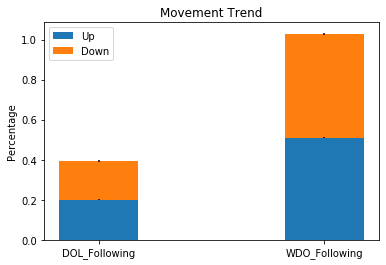

Dia 02/01 
 Porcetagem DOL seguiu WDO em up : 0.20024548483254428, Porcetagem DOL seguiu WDO em down: 0.1935374149659864,
 Porcetagem WDO seguiu DOL em up: 0.5105325443786982, Porcetagem WDO seguiu DOL em down: 0.519187917801436
 Instabilidade causada por WDO: 0.5836146520884768, por DOL: 0.41638534791152315  


In [145]:
plot()
print('Dia 02/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

In [146]:
Values_ = [e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol)]
dh[2] =  pd.DataFrame(Values_).T.rename({0: 'DOL_FOL_UP', 1:'DOL_FOL_DOWN', 2: 'WDO_FOL_UP', 3: 'WDO_FOL_DOWN', 4: 'WDO_BEGAN', 5: 'DOL_BEGAN' }, axis = 1)

## Dia 03/01/2020

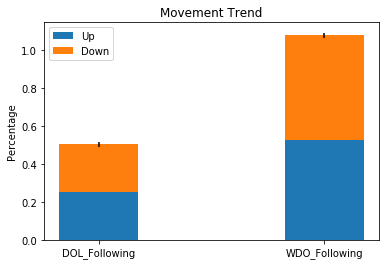

Dia 03/01 
 Porcetagem DOL seguiu WDO em up : 0.25113924050632913, Porcetagem DOL seguiu WDO em down: 0.25215692658310274,
 Porcetagem WDO seguiu DOL em up: 0.5258157045536035, Porcetagem WDO seguiu DOL em down: 0.5523758099352052
 Instabilidade causada por WDO: 0.5201275752090337, por DOL: 0.4798724247909663  


In [11]:
plot()
print('Dia 03/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

In [14]:
Values_ = [e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol)]
dh[3] =  pd.DataFrame(Values_).T.rename({0: 'DOL_FOL_UP', 1:'DOL_FOL_DOWN', 2: 'WDO_FOL_UP', 3: 'WDO_FOL_DOWN', 4: 'WDO_BEGAN', 5: 'DOL_BEGAN' }, axis = 1)

## Dia 06/01/2020

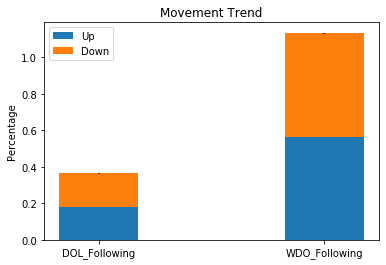

Dia 06/01 
 Porcetagem DOL seguiu WDO em up : 0.18021950611124968, Porcetagem DOL seguiu WDO em down: 0.18439201451905626,
 Porcetagem WDO seguiu DOL em up: 0.564297124600639, Porcetagem WDO seguiu DOL em down: 0.568584511248258
 Instabilidade causada por WDO: 0.618796078133313, por DOL: 0.38120392186668695  


In [11]:
plot()
print('Dia 06/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

## Dia 07/01/2020

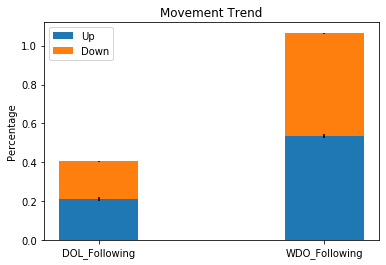

Dia 07/01 
 Porcetagem DOL seguiu WDO em up : 0.210638060118449, Porcetagem DOL seguiu WDO em down: 0.19475446428571427,
 Porcetagem WDO seguiu DOL em up: 0.5350500715307582, Porcetagem WDO seguiu DOL em down: 0.5281090289608177
 Instabilidade causada por WDO: 0.5606549165701405, por DOL: 0.43934508342985945  


In [14]:
plot()
print('Dia 07/01 \n Porcetagem DOL seguiu WDO em up : {}, Porcetagem DOL seguiu WDO em down: {},\n Porcetagem WDO seguiu DOL em up: {}, Porcetagem WDO seguiu DOL em down: {}\n Instabilidade causada por WDO: {}, por DOL: {}  '.format(e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol) ))

In [8]:
DATE = ['2020-01-02',
    '2020-01-06',
    '2020-01-03',
    '2020-01-07',
    '2020-01-16',
    '2020-01-09',
    '2020-01-10',
    '2020-01-08']

In [14]:
dh = {}
j = 0
for k in DATE:
    e = Causality("DOLG20", "WDOG20", k)
    e.operacoes()
    Values_ = [e.follow_up_wdo/(e.follow_up_wdo+e.not_follow_up_wdo), e.follow_down_wdo/(e.follow_down_wdo+e.not_follow_down_wdo), e.follow_up/(e.follow_up+e.not_follow_up), e.follow_down/(e.follow_down+e.not_follow_down), e.aux_wdo/(e.aux_wdo + e.aux_dol), e.aux_dol/(e.aux_wdo + e.aux_dol)]
    dh[j] =  pd.DataFrame(Values_).T.rename({0: 'DOL_FOL_UP', 1:'DOL_FOL_DOWN', 2: 'WDO_FOL_UP', 3: 'WDO_FOL_DOWN', 4: 'WDO_BEGAN', 5: 'DOL_BEGAN' }, axis = 1)
    j+=1
    


/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'so

In [18]:
pd.concat(dh).mean()

DOL_FOL_UP      0.201773
DOL_FOL_DOWN    0.205126
WDO_FOL_UP      0.539066
WDO_FOL_DOWN    0.531606
WDO_BEGAN       0.578948
DOL_BEGAN       0.421052
dtype: float64

In [19]:
pd.concat(dh)

,,DOL_FOL_UP,DOL_FOL_DOWN,WDO_FOL_UP,WDO_FOL_DOWN,WDO_BEGAN,DOL_BEGAN
0,0,0.188300,0.202805,0.518159,0.531755,0.578404,0.421596
1,0,0.180220,0.184392,0.564297,0.568585,0.618796,0.381204
2,0,0.260106,0.253415,0.550807,0.566273,0.516220,0.483780
3,0,0.210638,0.194754,0.535050,0.528109,0.560655,0.439345
4,0,0.175274,0.204620,0.495997,0.478904,0.590594,0.409406
5,0,0.212236,0.194938,0.537803,0.534961,0.550863,0.449137
6,0,0.193961,0.208149,0.564187,0.517080,0.604966,0.395034
7,0,0.193449,0.197933,0.546225,0.527184,0.611083,0.388917


# Analyses of distortion w/o trades

In [8]:
def get_trades(dol, wdo, date_):
    trades = pr.get_parquet(symbol=dol,
                                date=date_,
                                type_='trades')
    md_trades = trades.read().to_pandas()
    trades_wdo = pr.get_parquet(symbol=wdo,
                                date=date_,
                                type_='trades')
    md_trades_wdo = trades_wdo.read().to_pandas()
    return md_trades, md_trades_wdo 
md_trades, md_trades_wdo = get_trades("DOLG20", "WDOG20", "2020-01-06")

In [14]:
md_trades, md_trades_wdo = get_trades("DOLG20", "WDOG20", "2020-01-06")

In [15]:
total_.head()

,timestamp,event_type,side,symbol,msg_seq_num,ask_0,ask_quantity_0,bid_0,bid_quantity_0,ask_wdo_0,ask_quantity_wdo_0,bid_wdo_0,bid_quantity_wdo_0,spread_dol,spread_wdo,mid_price,mid_price_wdo,repeat
0,2020-01-06 12:00:50.186000+00:00,INSERT,B,WDO,21223,4065.0,5.0,4064.5,5.0,4065.0,22.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
1,2020-01-06 12:00:50.186000+00:00,CHANGE,A,WDO,21224,4065.0,5.0,4064.5,5.0,4065.0,17.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
2,2020-01-06 12:00:50.186000+00:00,CHANGE,A,WDO,21225,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
3,2020-01-06 12:00:50.186000+00:00,DELETE,B,WDO,21226,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.5,5.0,0.5,0.5,4064.75,4064.75,True
4,2020-01-06 12:00:50.186000+00:00,DELETE,B,WDO,21227,4065.0,5.0,4064.5,5.0,4065.0,10.0,4064.0,118.0,0.5,1.0,4064.75,4064.50,True


In [16]:
# trial = []
# for i in list_of_trades:
#     trial.append(np.where( (total_[i:]['spread_wdo'] == 0.5) & (total_[i:]['spread_dol'] == 0.5) & (total_[i:]['ask_0'] == total_[i:]['ask_wdo_0']) & (total_[i:]['bid_0'] == total_[i:]['bid_wdo_0']))[0])


In [17]:
all_trades =  pd.concat([md_trades,md_trades_wdo]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()

In [18]:
all_trades.head()

,ts,msg_seq_num,symbol,trade_id,price,quantity,trade_ts,buyer,seller,crossed,deleted
0,2020-01-06 12:00:35.881000+00:00,15620,WDOG20,10,4062.0,10.0,12:00:35.878000,308,107,False,None
1,2020-01-06 12:00:35.881000+00:00,15620,WDOG20,20,4062.0,15.0,12:00:35.878000,3,107,False,None
2,2020-01-06 12:00:35.881000+00:00,15620,WDOG20,30,4062.0,1.0,12:00:35.878000,3,3701,False,None
3,2020-01-06 12:00:35.881000+00:00,15620,WDOG20,40,4062.0,10.0,12:00:35.878000,386,3701,False,None
4,2020-01-06 12:00:35.881000+00:00,15620,WDOG20,50,4062.0,1.0,12:00:35.878000,1982,3701,False,None


In [19]:
list_of_trades = all_trades.groupby('msg_seq_num').sum().index


In [20]:
# Todas as operações que não foram trades
w_o_trade = total_#[~total_['msg_seq_num'].isin(list_of_trades)].reset_index()

In [24]:
# Posicoes de algum dos spreads abertos
index_trade = np.where((w_o_trade['spread_dol'] != 0.5) | (w_o_trade['spread_wdo'] != 0.5) )[0]

#Procura as posicoes no vetor anterior, onde os momento de spread aberto nao sao consecutivos
position_trade = np.where(np.diff(np.where((w_o_trade['spread_dol'] != 0.5) | (w_o_trade['spread_wdo'] != 0.5) )) != 1)[1] +1

#Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de spread aberto
Open_Spread = []
for i in position_trade:
    Open_Spread.append(index_trade[i])

In [25]:
Open_Spread[0:15]

[12,
 17,
 459,
 746,
 1061,
 1096,
 1129,
 1233,
 2107,
 3216,
 3344,
 3514,
 3533,
 3648,
 4107]

In [26]:
# Posicoes do mercado 100% estavel
index_stable  = np.where( (w_o_trade['spread_wdo'] == 0.5) & (w_o_trade['spread_dol'] == 0.5) & (w_o_trade['ask_0'] == w_o_trade['ask_wdo_0']) & (w_o_trade['bid_0'] == w_o_trade['bid_wdo_0']))[0]

#Procura as posicoes no vetor anterior, onde os momento de spread aberto nao sao consecutivos
position_stable = np.where(np.diff(np.where( (w_o_trade['spread_wdo'] == 0.5) & (w_o_trade['spread_dol'] == 0.5) & (w_o_trade['ask_0'] == w_o_trade['ask_wdo_0']) & (w_o_trade['bid_0'] == w_o_trade['bid_wdo_0']))
) != 1)[1] + 1

In [27]:
index_stable

array([      0,       1,       2, ..., 3087505, 3087506, 3087507])

In [28]:
#Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de estabilidade
all_stable = []
for i in position_stable:
    all_stable.append(index_stable[i])

In [29]:
all_stable[0:10]

[4132, 6324, 6334, 6395, 6612, 6751, 6909, 6977, 7063, 7267]

In [30]:
# Posicoes de ambos os spreads fechado

index_spread_closed = np.where((w_o_trade['spread_dol'] == 0.5) & (w_o_trade['spread_wdo'] == 0.5) )[0]



In [32]:
# Diferenca entra todos momentos de ambos os spread fechados e todos os momentos de total estabilidade do mercado -- 
#retornando apenas momentos de spread fechado com instantes de estabilidade

list_ = list(set(index_spread_closed).difference(set(index_stable)))

In [33]:
list_.sort()

In [34]:
list_[0:9]

[11, 14, 15, 16, 455, 456, 457, 458, 737]

In [36]:
#Procura por posicoes nao consecutivas 
position_final = np.where( np.diff(list_) !=1)[0] + 1

In [38]:
# #Procura os indices que no dataframe correspondem ao primeiro momento dos eventos de instabilidade
#Calcula o primeiro momento de mercado distocido com spread fechado

init_distortion = []
for i in position_final:
    init_distortion.append(list_[i])

In [39]:
init_distortion[0:15]

[14,
 455,
 737,
 1059,
 1093,
 1128,
 1206,
 2096,
 3206,
 3339,
 3508,
 3528,
 3635,
 4105,
 4148]

In [41]:
all_stable[0:5]

[4132, 6324, 6334, 6395, 6612]

In [42]:
w_o_trade.columns

Index(['timestamp', 'event_type', 'side', 'symbol', 'msg_seq_num', 'ask_0',
       'ask_quantity_0', 'bid_0', 'bid_quantity_0', 'ask_wdo_0',
       'ask_quantity_wdo_0', 'bid_wdo_0', 'bid_quantity_wdo_0', 'spread_dol',
       'spread_wdo', 'mid_price', 'mid_price_wdo', 'repeat'],
      dtype='object')

In [43]:
pd.set_option('display.max_columns', 100) 


In [44]:
only_price = w_o_trade[['ask_0', 'bid_0','ask_wdo_0','bid_wdo_0']]

In [45]:
only_price

,ask_0,bid_0,ask_wdo_0,bid_wdo_0
0,4065.0,4064.5,4065.0,4064.5
1,4065.0,4064.5,4065.0,4064.5
2,4065.0,4064.5,4065.0,4064.5
3,4065.0,4064.5,4065.0,4064.5
4,4065.0,4064.5,4065.0,4064.0
...,...,...,...,...
3087745,4068.0,4067.0,4067.5,4066.5
3087746,4068.0,4067.0,4067.5,4066.5
3087747,4068.0,4067.0,4067.5,4066.5
3087748,4068.0,4067.0,4067.5,4066.5


In [50]:
#holder = init_distortion.copy()

In [51]:
init_distortion = holder.copy()

In [52]:
init_distortion[0:25]

[14,
 455,
 737,
 1059,
 1093,
 1128,
 1206,
 2096,
 3206,
 3339,
 3508,
 3528,
 3635,
 4105,
 4148,
 4288,
 4935,
 5162,
 5294,
 5317,
 5748,
 5991,
 6003,
 6348,
 6528]

In [53]:
all_stable[0:15]

[4132,
 6324,
 6334,
 6395,
 6612,
 6751,
 6909,
 6977,
 7063,
 7267,
 7740,
 8063,
 8110,
 8118,
 8123]

In [54]:
i = 0
j = 0
l = {}
kj = {}


while(True):
    if init_distortion[i] > all_stable[j]:
        if init_distortion[0] < all_stable[j]:
            l[j] = only_price.loc[init_distortion[0]] - only_price.loc[all_stable[j]]
            kj[j] = w_o_trade.loc[init_distortion[0]]
#             print('\n',init_distortion[0], all_stable[j],j,i )
            init_distortion = init_distortion[i:]
#             print(init_distortion[0])
            i = 0
#             print(init_distortion[i])
            j+=1
        else:
            j+=1
    else:
        i+=1

IndexError: list index out of range

In [55]:
kj[0]

timestamp             2020-01-06 12:00:50.186000+00:00
event_type                                      INSERT
side                                                 A
symbol                                             WDO
msg_seq_num                                      21237
ask_0                                             4065
ask_quantity_0                                       5
bid_0                                           4064.5
bid_quantity_0                                       5
ask_wdo_0                                       4064.5
ask_quantity_wdo_0                                   5
bid_wdo_0                                         4064
bid_quantity_wdo_0                                  98
spread_dol                                         0.5
spread_wdo                                         0.5
mid_price                                      4064.75
mid_price_wdo                                  4064.25
repeat                                            True
Name: 14, 

In [56]:
all_events = {}
for i in kj.keys():
    all_events[i] = pd.DataFrame(kj[i]).T
    all_events[i]['mover'] = -1
    all_events[i].loc[all_events[i]['ask_0'] < all_events[i]['ask_wdo_0'], 'mover'] = 1

In [57]:
all_events[0]

,timestamp,event_type,side,symbol,msg_seq_num,ask_0,ask_quantity_0,bid_0,bid_quantity_0,ask_wdo_0,ask_quantity_wdo_0,bid_wdo_0,bid_quantity_wdo_0,spread_dol,spread_wdo,mid_price,mid_price_wdo,repeat,mover
14,2020-01-06 12:00:50.186000+00:00,INSERT,A,WDO,21237,4065,5,4064.5,5,4064.5,5,4064,98,0.5,0.5,4064.75,4064.25,True,-1


In [58]:
df_all_events = pd.concat(all_events)#.drop(['index'], axis =1 )

In [59]:
df_all_events

,,timestamp,event_type,side,symbol,msg_seq_num,ask_0,ask_quantity_0,bid_0,bid_quantity_0,ask_wdo_0,ask_quantity_wdo_0,bid_wdo_0,bid_quantity_wdo_0,spread_dol,spread_wdo,mid_price,mid_price_wdo,repeat,mover
0,14,2020-01-06 12:00:50.186000+00:00,INSERT,A,WDO,21237,4065,5,4064.5,5,4064.5,5,4064,98,0.5,0.5,4064.75,4064.25,True,-1
1,4148,2020-01-06 12:00:56.659000+00:00,INSERT,A,DOL,25629,4062.5,20,4062,5,4063,33,4062.5,17,0.5,0.5,4062.25,4062.75,True,1
3,6348,2020-01-06 12:01:01.113000+00:00,INSERT,B,WDO,27907,4063,5,4062.5,15,4063.5,116,4063,17,0.5,0.5,4062.75,4063.25,True,1
4,6528,2020-01-06 12:01:01.175000+00:00,INSERT,B,WDO,28092,4063.5,5,4063,5,4064,135,4063.5,3,0.5,0.5,4063.25,4063.75,True,1
5,6729,2020-01-06 12:01:01.489000+00:00,INSERT,A,DOL,28296,4063.5,10,4063,15,4064,78,4063.5,36,0.5,0.5,4063.25,4063.75,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9439,3086813,2020-01-06 21:14:36.529000+00:00,INSERT,B,DOL,3346363,4067,25,4066.5,30,4066.5,45,4066,14,0.5,0.5,4066.75,4066.25,True,-1
9442,3086948,2020-01-06 21:14:41.501000+00:00,DELETE_FROM,B,WDO,3346504,4066.5,25,4066,170,4066,1,4065.5,142,0.5,0.5,4066.25,4065.75,True,-1
9445,3087080,2020-01-06 21:14:44.984000+00:00,DELETE_FROM,B,WDO,3346643,4067,15,4066.5,5,4066.5,10,4066,42,0.5,0.5,4066.75,4066.25,True,-1
9446,3087113,2020-01-06 21:14:45.426000+00:00,DELETE,B,WDO,3346677,4067,15,4066.5,5,4066.5,5,4066,25,0.5,0.5,4066.75,4066.25,True,-1


In [60]:
all_movements = {}
for i in l.keys():
    all_movements[i] = pd.DataFrame(l[i]).T

In [61]:
for i in all_movements.keys():
    all_movements[i]['symbol'] = all_events[i]['symbol'].values[0]
    all_movements[i]['side'] = all_events[i]['side'].values[0]
    all_movements[i]['mover'] = all_events[i]['mover'].values[0]
    all_movements[i]['mover'] = all_events[i]['mover'].values[0]
    all_movements[i]['MODO'] = 'Final'
    all_movements[i]['msg_seq_num'] = all_events[i]['msg_seq_num'].values[0]

In [62]:
all_movements[0]

,ask_0,bid_0,ask_wdo_0,bid_wdo_0,symbol,side,mover,MODO,msg_seq_num
0,2.0,2.0,1.5,1.5,WDO,A,-1,Final,21237


In [63]:
df_all_movements = pd.concat(all_movements)

In [64]:
df_all_movements

,,ask_0,bid_0,ask_wdo_0,bid_wdo_0,symbol,side,mover,MODO,msg_seq_num
0,0,2.0,2.0,1.5,1.5,WDO,A,-1,Final,21237
1,0,-0.5,-0.5,0.0,0.0,DOL,A,1,Final,25629
3,0,-0.5,-0.5,0.0,0.0,WDO,B,1,Final,27907
4,0,-0.5,-0.5,0.0,0.0,WDO,B,1,Final,28092
5,0,0.0,0.0,0.5,0.5,DOL,A,1,Final,28296
...,...,...,...,...,...,...,...,...,...,...
9439,0,0.0,0.0,-0.5,-0.5,DOL,B,-1,Final,3346363
9442,0,0.0,0.0,-0.5,-0.5,WDO,B,-1,Final,3346504
9445,0,0.0,0.0,-0.5,-0.5,WDO,B,-1,Final,3346643
9446,0,0.0,0.0,-0.5,-0.5,WDO,B,-1,Final,3346677


In [65]:
dataframe= {}
for i in all_events.keys():
    dataframe[i] = pd.concat([all_events[i], all_movements[i]]).fillna(method = 'ffill').reset_index().drop(['index'], axis =1)
    

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
all_final = pd.concat(dataframe)

In [70]:
all_final.head()

MODO   ask_0  ask_quantity_0  ask_quantity_wdo_0  ask_wdo_0   bid_0  \
0 0    NaN  4065.0             5.0                 5.0     4064.5  4064.5   
  1  Final     2.0             5.0                 5.0        1.5     2.0   
1 0    NaN  4062.5            20.0                33.0     4063.0  4062.0   
  1  Final    -0.5            20.0                33.0        0.0    -0.5   
3 0    NaN  4063.0             5.0               116.0     4063.5  4062.5   

     bid_quantity_0  bid_quantity_wdo_0  bid_wdo_0 event_type  mid_price  \
0 0             5.0                98.0     4064.0     INSERT    4064.75   
  1             5.0                98.0        1.5     INSERT    4064.75   
1 0             5.0                17.0     4062.5     INSERT    4062.25   
  1             5.0                17.0        0.0     INSERT    4062.25   
3 0            15.0                17.0     4063.0     INSERT    4062.75   

     mid_price_wdo  mover  msg_seq_num  repeat side  spread_dol  spread_wdo  \
0 0        4064.25     -1        21237    True    A         0.5         0.5   
  1        4064.25     -1        21237    True    A         0.5         0.5   
1 0        4062.75      1        25629    True    A         0.5         0.5   
  1        4062.75      1        25629    True    A         0.5         0.5   
3 0        4063.25      1        27907    True    B         0.5         0.5   

    symbol                        timestamp  
0 0    WDO 2020-01-06 12:00:50.186000+00:00  
  1    WDO 2020-01-06 12:00:50.186000+00:00  
1 0    DOL 2020-01-06 12:00:56.659000+00:00  
  1    DOL 2020-01-06 12:00:56.659000+00:00  
3 0    WDO 2020-01-06 12:01:01.113000+00:00

In [71]:
all_final_ = all_final[[ 'timestamp', 'symbol', 'side', 'ask_0', 'bid_0', 'ask_quantity_0', 'ask_quantity_wdo_0',
       'ask_wdo_0', 'bid_wdo_0', 'bid_quantity_0', 'bid_quantity_wdo_0',
        'event_type', 'mid_price', 'mid_price_wdo',
       'mover', 'msg_seq_num', 'spread_dol', 'spread_wdo', 'MODO']]

## Tabela final para análises gerais

In [110]:
all_final_.head()

timestamp symbol side   ask_0   bid_0  \
0    0 2020-01-06 12:00:50.186000+00:00    WDO    A  4065.0  4064.5   
     1 2020-01-06 12:00:50.186000+00:00    WDO    A     2.0     2.0   
1    0 2020-01-06 12:00:56.659000+00:00    DOL    A  4062.5  4062.0   
     1 2020-01-06 12:00:56.659000+00:00    DOL    A    -0.5    -0.5   
3    0 2020-01-06 12:01:01.113000+00:00    WDO    B  4063.0  4062.5   
...                                 ...    ...  ...     ...     ...   
9445 1 2020-01-06 21:14:44.984000+00:00    WDO    B     0.0     0.0   
9446 0 2020-01-06 21:14:45.426000+00:00    WDO    B  4067.0  4066.5   
     1 2020-01-06 21:14:45.426000+00:00    WDO    B     0.0     0.0   
9448 0 2020-01-06 21:14:46.438000+00:00    WDO    B  4067.0  4066.5   
     1 2020-01-06 21:14:46.438000+00:00    WDO    B     0.0     0.0   

        ask_quantity_0  ask_quantity_wdo_0  ask_wdo_0  bid_wdo_0  \
0    0             5.0                 5.0     4064.5     4064.0   
     1             5.0                 5.0        1.5        1.5   
1    0            20.0                33.0     4063.0     4062.5   
     1            20.0                33.0        0.0        0.0   
3    0             5.0               116.0     4063.5     4063.0   
...                ...                 ...        ...        ...   
9445 1            15.0                10.0       -0.5       -0.5   
9446 0            15.0                 5.0     4066.5     4066.0   
     1            15.0                 5.0       -0.5       -0.5   
9448 0            15.0                 2.0     4066.5     4066.0   
     1            15.0                 2.0       -0.5       -0.5   

        bid_quantity_0  bid_quantity_wdo_0   event_type  mid_price  \
0    0             5.0                98.0       INSERT    4064.75   
     1             5.0                98.0       INSERT    4064.75   
1    0             5.0                17.0       INSERT    4062.25   
     1             5.0                17.0       INSERT    4062.25   
3    0            15.0                17.0       INSERT    4062.75   
...                ...                 ...          ...        ...   
9445 1             5.0                42.0  DELETE_FROM    4066.75   
9446 0             5.0                25.0       DELETE    4066.75   
     1             5.0                25.0       DELETE    4066.75   
9448 0             5.0                25.0  DELETE_FROM    4066.75   
     1             5.0                25.0  DELETE_FROM    4066.75   

        mid_price_wdo  mover  msg_seq_num  spread_dol  spread_wdo   MODO  
0    0        4064.25     -1        21237         0.5         0.5    NaN  
     1        4064.25     -1        21237         0.5         0.5  Final  
1    0        4062.75      1        25629         0.5         0.5    NaN  
     1        4062.75      1        25629         0.5         0.5  Final  
3    0        4063.25      1        27907         0.5         0.5    NaN  
...               ...    ...          ...         ...         ...    ...  
9445 1        4066.25     -1      3346643         0.5         0.5  Final  
9446 0        4066.25     -1      3346677         0.5         0.5    NaN  
     1        4066.25     -1      3346677         0.5         0.5  Final  
9448 0        4066.25     -1      3346767         0.5         0.5    NaN  
     1        4066.25     -1      3346767         0.5         0.5  Final  

[10486 rows x 19 columns]

In [111]:
all_final_w_t = all_final_[~all_final_['msg_seq_num'].isin(list_of_trades)].reset_index()
all_final_w_t = all_final_w_t[all_final_w_t.event_type != 'DELETE_FROM']

In [112]:
all_final_w_t.head()

,level_0,level_1,timestamp,symbol,side,ask_0,bid_0,ask_quantity_0,ask_quantity_wdo_0,ask_wdo_0,bid_wdo_0,bid_quantity_0,bid_quantity_wdo_0,event_type,mid_price,mid_price_wdo,mover,msg_seq_num,spread_dol,spread_wdo,MODO
0,0,0,2020-01-06 12:00:50.186000+00:00,WDO,A,4065.0,4064.5,5.0,5.0,4064.5,4064.0,5.0,98.0,INSERT,4064.75,4064.25,-1,21237,0.5,0.5,NaN
1,0,1,2020-01-06 12:00:50.186000+00:00,WDO,A,2.0,2.0,5.0,5.0,1.5,1.5,5.0,98.0,INSERT,4064.75,4064.25,-1,21237,0.5,0.5,Final
2,1,0,2020-01-06 12:00:56.659000+00:00,DOL,A,4062.5,4062.0,20.0,33.0,4063.0,4062.5,5.0,17.0,INSERT,4062.25,4062.75,1,25629,0.5,0.5,NaN
3,1,1,2020-01-06 12:00:56.659000+00:00,DOL,A,-0.5,-0.5,20.0,33.0,0.0,0.0,5.0,17.0,INSERT,4062.25,4062.75,1,25629,0.5,0.5,Final
4,3,0,2020-01-06 12:01:01.113000+00:00,WDO,B,4063.0,4062.5,5.0,116.0,4063.5,4063.0,15.0,17.0,INSERT,4062.75,4063.25,1,27907,0.5,0.5,NaN


In [109]:
# tips = all_final_[ (all_final_['symbol'] == 'WDO') & (all_final_['side'] == 'B')]# & (all_final_['mover'] == 1) & (all_final_['MODO'] == 'Final')]

## Estudo de trend following

In [113]:
all_final_w_t.loc[(all_final_w_t['side'] == 'A') & (all_final_w_t['symbol'] == 'DOL'), 'qntd'] = all_final_w_t['ask_quantity_0']
all_final_w_t.loc[(all_final_w_t['side'] == 'A') & (all_final_w_t['symbol'] == 'WDO'), 'qntd'] = all_final_w_t['ask_quantity_wdo_0']
all_final_w_t.loc[(all_final_w_t['side'] == 'B') & (all_final_w_t['symbol'] == 'DOL'), 'qntd'] = all_final_w_t['bid_quantity_0']
all_final_w_t.loc[(all_final_w_t['side'] == 'B') & (all_final_w_t['symbol'] == 'WDO'), 'qntd'] = all_final_w_t['bid_quantity_wdo_0']


In [114]:
aux_1= all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['symbol'] == 'DOL' )].shape[0]
aux_2 = all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['symbol'] == 'DOL' )].shape[0]


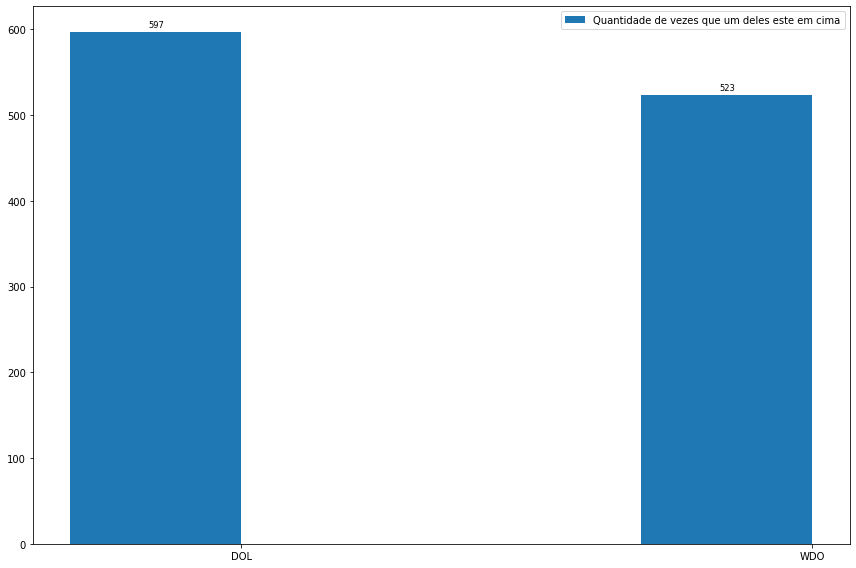

In [123]:
labels = ['DOL', 'WDO']# [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])-12)] 
qntd_insert = [aux_1,aux_2]
# qntd_ocorrencias = [aux10[0], aux12[0], aux14[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Quantidade de vezes que um deles este em cima' )
# rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Total de vezes que o WDO esteve acima do DOL')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quantidade')
# ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()


## Analise de valores agrupados

In [124]:
df_final_analysis = all_final_w_t[(all_final_w_t['MODO'] == 'Final') & (all_final_w_t['symbol'] == 'DOL' )]
aux1= df_final_analysis.groupby(["mover", "qntd"]).sum()[["ask_0", "bid_0", "ask_wdo_0", "bid_wdo_0"]].reset_index()



In [125]:
aux1

,mover,qntd,ask_0,bid_0,ask_wdo_0,bid_wdo_0
0,-1,5.0,31.0,31.0,-123.0,-123.0
1,-1,10.0,13.5,13.5,-106.0,-106.0
2,-1,15.0,0.5,0.5,-4.5,-4.5
3,-1,20.0,0.5,0.5,-8.0,-8.0
4,-1,25.0,0.0,0.0,-1.0,-1.0
5,-1,30.0,0.0,0.0,-0.5,-0.5
6,-1,35.0,0.0,0.0,-0.5,-0.5
7,-1,40.0,0.0,0.0,-1.5,-1.5
8,-1,50.0,0.0,0.0,-4.0,-4.0
9,-1,60.0,0.0,0.0,-0.5,-0.5


In [126]:
aux2 = df_final_analysis.groupby(["mover", "qntd"]).count()[["ask_0", "bid_0", "ask_wdo_0", "bid_wdo_0"]].reset_index()
aux2

,mover,qntd,ask_0,bid_0,ask_wdo_0,bid_wdo_0
0,-1,5.0,308,308,308,308
1,-1,10.0,239,239,239,239
2,-1,15.0,9,9,9,9
3,-1,20.0,17,17,17,17
4,-1,25.0,2,2,2,2
5,-1,30.0,1,1,1,1
6,-1,35.0,1,1,1,1
7,-1,40.0,3,3,3,3
8,-1,50.0,8,8,8,8
9,-1,60.0,1,1,1,1


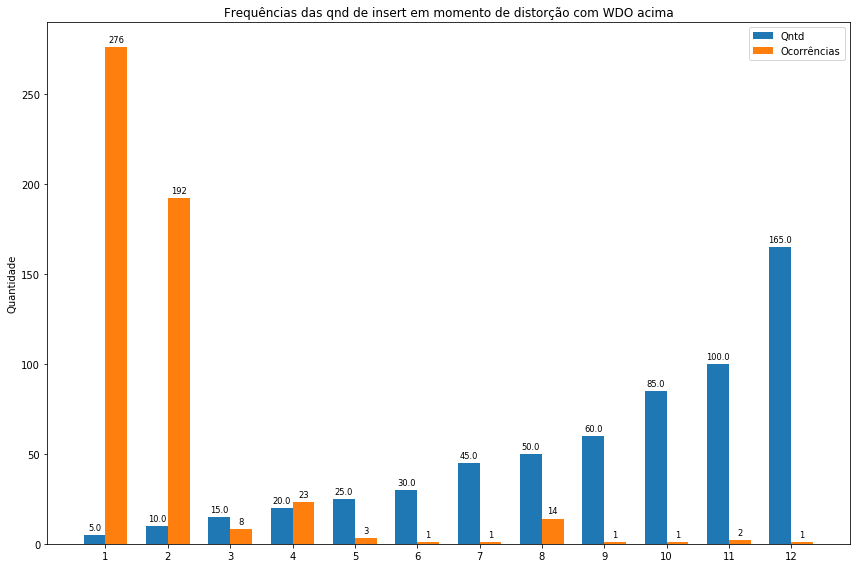

In [127]:
labels =  [i for i in range(1, (aux2[aux2['mover'] == 1]['qntd'].shape[0])+1)] 
qntd_insert = aux2[aux2['mover'] == 1]['qntd']
qntd_ocorrencias = aux2[aux2['mover'] == 1]['ask_0']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Qntd')
rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Ocorrências')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantidade')
ax.set_title('Frequências das qnd de insert em momento de distorção com WDO acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize='small')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


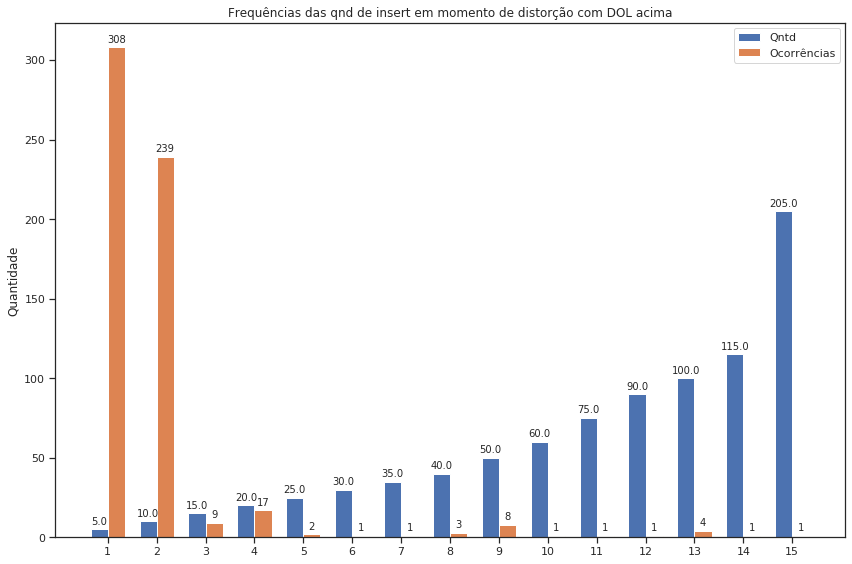

In [131]:
labels =  [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])+1)] 
qntd_insert = aux2[aux2['mover'] == -1]['qntd']
qntd_ocorrencias = aux2[aux2['mover'] == -1]['ask_0']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Qntd')
rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Ocorrências')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantidade')
ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [128]:
all_final_w_t

,level_0,level_1,timestamp,symbol,side,ask_0,bid_0,ask_quantity_0,ask_quantity_wdo_0,ask_wdo_0,bid_wdo_0,bid_quantity_0,bid_quantity_wdo_0,event_type,mid_price,mid_price_wdo,mover,msg_seq_num,spread_dol,spread_wdo,MODO,qntd
0,0,0,2020-01-06 12:00:50.186000+00:00,WDO,A,4065.0,4064.5,5.0,5.0,4064.5,4064.0,5.0,98.0,INSERT,4064.75,4064.25,-1,21237,0.5,0.5,NaN,5.0
1,0,1,2020-01-06 12:00:50.186000+00:00,WDO,A,2.0,2.0,5.0,5.0,1.5,1.5,5.0,98.0,INSERT,4064.75,4064.25,-1,21237,0.5,0.5,Final,5.0
2,1,0,2020-01-06 12:00:56.659000+00:00,DOL,A,4062.5,4062.0,20.0,33.0,4063.0,4062.5,5.0,17.0,INSERT,4062.25,4062.75,1,25629,0.5,0.5,NaN,20.0
3,1,1,2020-01-06 12:00:56.659000+00:00,DOL,A,-0.5,-0.5,20.0,33.0,0.0,0.0,5.0,17.0,INSERT,4062.25,4062.75,1,25629,0.5,0.5,Final,20.0
4,3,0,2020-01-06 12:01:01.113000+00:00,WDO,B,4063.0,4062.5,5.0,116.0,4063.5,4063.0,15.0,17.0,INSERT,4062.75,4063.25,1,27907,0.5,0.5,NaN,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6653,9423,1,2020-01-06 21:13:58.695000+00:00,WDO,A,0.5,0.5,25.0,2.0,0.0,0.0,5.0,35.0,INSERT,4068.25,4067.75,-1,3345280,0.5,0.5,Final,2.0
6654,9425,0,2020-01-06 21:14:05.312000+00:00,WDO,A,4068.0,4067.5,10.0,5.0,4067.5,4067.0,5.0,29.0,INSERT,4067.75,4067.25,-1,3345464,0.5,0.5,NaN,5.0
6655,9425,1,2020-01-06 21:14:05.312000+00:00,WDO,A,0.5,0.5,10.0,5.0,0.0,0.0,5.0,29.0,INSERT,4067.75,4067.25,-1,3345464,0.5,0.5,Final,5.0
6656,9433,0,2020-01-06 21:14:19.960000+00:00,DOL,B,4067.0,4066.5,25.0,5.0,4066.5,4066.0,5.0,114.0,INSERT,4066.75,4066.25,-1,3345958,0.5,0.5,NaN,5.0


In [129]:
aux3= all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_wdo_0'] != 0 ) & (all_final_w_t['qntd'] > 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux4 = all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] > 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape

aux5= all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_wdo_0'] != 0 ) & (all_final_w_t['qntd'] == 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux6 = all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] == 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape

aux7= all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_wdo_0'] != 0 ) & (all_final_w_t['qntd'] >=20 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux8 = all_final_w_t[ (all_final_w_t['mover'] == -1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] >= 20)  & (all_final_w_t['symbol'] == 'DOL' )].shape

aux9= all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_0'] != 0 ) & (all_final_w_t['qntd'] > 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux10 = all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] > 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape

aux11= all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_0'] != 0 ) & (all_final_w_t['qntd'] == 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux12 = all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] == 5 )  & (all_final_w_t['symbol'] == 'DOL' )].shape

aux13= all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_0'] != 0 ) & (all_final_w_t['qntd'] >=20 )  & (all_final_w_t['symbol'] == 'DOL' )].shape
aux14 = all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final')  & (all_final_w_t['qntd'] >= 20)  & (all_final_w_t['symbol'] == 'DOL' )].shape

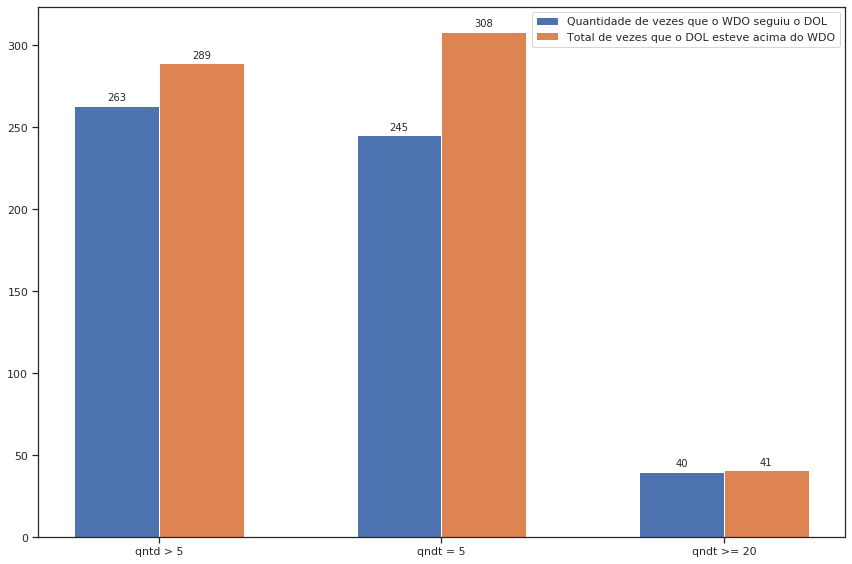

In [281]:
labels = ['qntd > 5', 'qndt = 5', 'qndt >= 20']# [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])-12)] 
qntd_insert = [aux3[0],aux5[0], aux7[0]]
qntd_ocorrencias = [aux4[0], aux6[0], aux8[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Quantidade de vezes que o WDO seguiu o DOL')
rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Total de vezes que o DOL esteve acima do WDO')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quantidade')
# ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

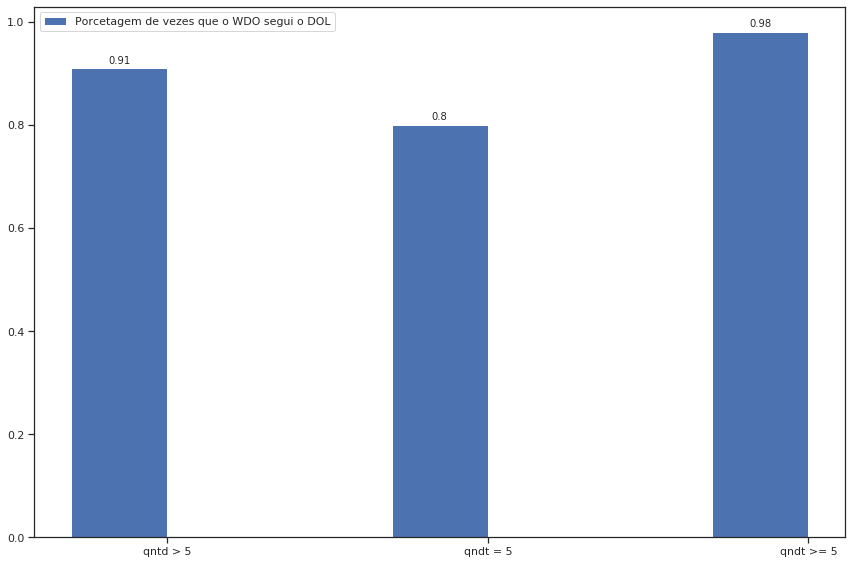

In [263]:
labels = ['qntd > 5', 'qndt = 5', 'qndt >= 5']# [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])-12)] 
qntd_insert = [(round(aux3[0]/aux4[0], 2)), (round(aux5[0]/aux6[0], 2)) ,(round(aux7[0]/aux8[0], 2)) ]

x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Porcetagem de vezes que o WDO segui o DOL')
# rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Ocorrência total de vezes que o DOL esteve acima do WDO')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quantidade')
# ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 2)

autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

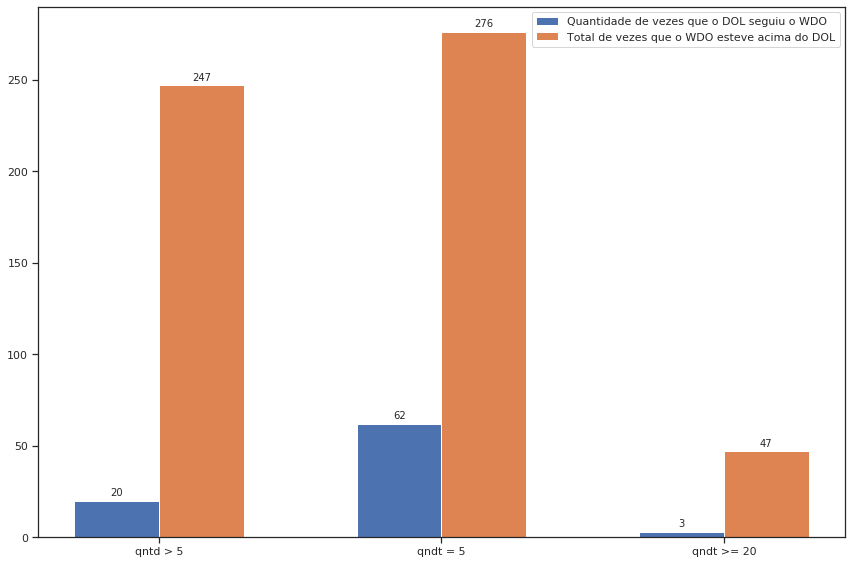

In [284]:
labels = ['qntd > 5', 'qndt = 5', 'qndt >= 20']# [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])-12)] 
qntd_insert = [aux9[0],aux11[0], aux13[0]]
qntd_ocorrencias = [aux10[0], aux12[0], aux14[0]]

x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Quantidade de vezes que o DOL seguiu o WDO')
rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Total de vezes que o WDO esteve acima do DOL')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quantidade')
# ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()



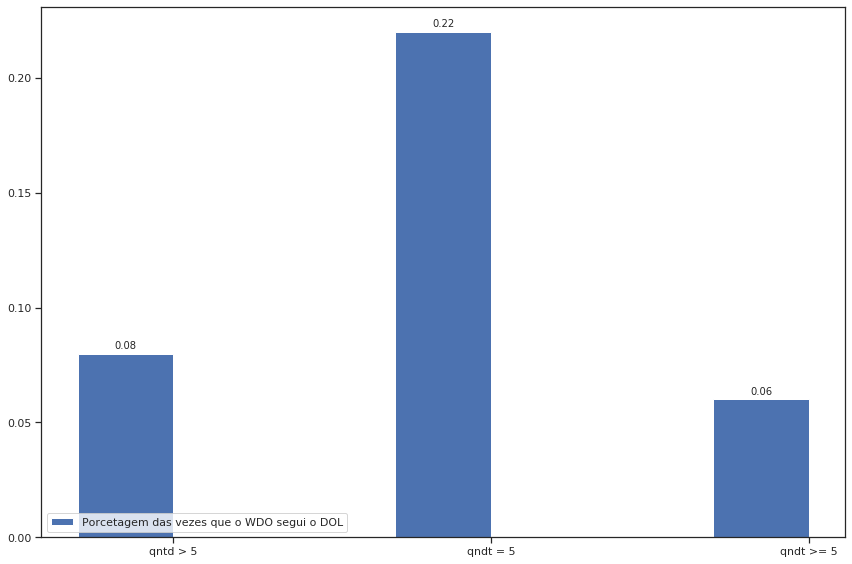

In [269]:
percentage = '{:.1f}%'.format(100 * aux11[0]/aux12[0])
labels = ['qntd > 5', 'qndt = 5', 'qndt >= 5']# [i for i in range(1, (aux2[aux2['mover'] == -1]['qntd'].shape[0])-12)] 
qntd_insert = [(round(aux9[0]/aux10[0], 2)), (round(aux11[0]/aux12[0], 2)) ,(round(aux13[0]/aux14[0], 2)) ]

x = np.arange(len(labels))  # the label locations
width = 0.3# the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Porcetagem das vezes que o WDO segui o DOL')
# rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Ocorrência total de vezes que o DOL esteve acima do WDO')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Quantidade')
# ax.set_title('Frequências das qnd de insert em momento de distorção com DOL acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 3)

autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [131]:
all_final_w_t[ (all_final_w_t['mover'] == 1) & (all_final_w_t['MODO'] == 'Final') & (all_final_w_t['ask_0'] != 0 ) & (all_final_w_t['qntd'] >=1 )  & (all_final_w_t['symbol'] == 'DOL' )]


,level_0,level_1,timestamp,symbol,side,ask_0,bid_0,ask_quantity_0,ask_quantity_wdo_0,ask_wdo_0,bid_wdo_0,bid_quantity_0,bid_quantity_wdo_0,event_type,mid_price,mid_price_wdo,mover,msg_seq_num,spread_dol,spread_wdo,MODO,qntd
3,1,1,2020-01-06 12:00:56.659000+00:00,DOL,A,-0.5,-0.5,20.0,33.0,0.0,0.0,5.0,17.0,INSERT,4062.25,4062.75,1,25629,0.5,0.5,Final,20.0
15,10,1,2020-01-06 12:01:02.770000+00:00,DOL,A,1.5,1.5,5.0,20.0,2.0,2.0,35.0,74.0,INSERT,4062.25,4062.75,1,28896,0.5,0.5,Final,5.0
19,20,1,2020-01-06 12:01:06.183000+00:00,DOL,A,-0.5,-0.5,5.0,96.0,0.0,0.0,5.0,47.0,INSERT,4060.75,4061.25,1,30411,0.5,0.5,Final,5.0
25,44,1,2020-01-06 12:01:22.625000+00:00,DOL,A,-0.5,-0.5,10.0,113.0,0.0,0.0,105.0,38.0,INSERT,4058.25,4058.75,1,35159,0.5,0.5,Final,10.0
71,120,1,2020-01-06 12:02:50.546000+00:00,DOL,A,-0.5,-0.5,5.0,169.0,0.0,0.0,45.0,24.0,INSERT,4058.75,4059.25,1,53095,0.5,0.5,Final,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,8451,1,2020-01-06 19:39:09.680000+00:00,DOL,A,-0.5,-0.5,5.0,510.0,0.0,0.0,170.0,107.0,INSERT,4073.25,4073.75,1,3035947,0.5,0.5,Final,5.0
6081,8621,1,2020-01-06 19:53:04.229000+00:00,DOL,A,-0.5,-0.5,5.0,312.0,0.0,0.0,85.0,61.0,INSERT,4070.75,4071.25,1,3106138,0.5,0.5,Final,5.0
6109,8658,1,2020-01-06 19:55:17.329000+00:00,DOL,A,-0.5,-0.5,5.0,306.0,0.0,0.0,130.0,75.0,INSERT,4070.75,4071.25,1,3117818,0.5,0.5,Final,5.0
6221,8823,1,2020-01-06 20:14:55.211000+00:00,DOL,A,-0.5,-0.5,5.0,394.0,0.0,0.0,80.0,19.0,INSERT,4070.25,4070.75,1,3188144,0.5,0.5,Final,5.0


In [430]:
all_final_w_t2 = all_final_w_t[(all_final_w_t['symbol'] == 'DOL' )]

# Estudo Trades do modelo

In [9]:
from asimov_strategy.managers.manager import Manager

In [11]:
manager = Manager()
# all_trades = manager._get_all_possible_trades('2020-01-06', 'Taker', {'signal' : 'insert_wo_trades'})  

[ Asynch ] STARTING THREAD. _run


In [6]:
df_final_analysis = all_final_w_t2[(all_final_w_t2['MODO'] == 'Final') ]
aux1= df_final_analysis.groupby(["mover", "qntd"]).sum()[["ask_0", "bid_0", "ask_wdo_0", "bid_wdo_0"]].reset_index()
aux2 = df_final_analysis.groupby(["mover", "qntd"]).count()[["ask_0", "bid_0", "ask_wdo_0", "bid_wdo_0"]].reset_index()
aux2
labels =  [i for i in range(1, (aux2[aux2['mover'] == 1]['qntd'].shape[0])+1)] 
qntd_insert = aux2[aux2['mover'] == 1]['qntd']
qntd_ocorrencias = aux2[aux2['mover'] == 1]['ask_0']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, qntd_insert, width, label='Qntd')
rects2 = ax.bar(x + width/2, qntd_ocorrencias, width, label='Ocorrências')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantidade')
ax.set_title('Frequências das qnd de insert em momento de distorção com WDO acima')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize='small')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [10]:
def fetch_with_fillrate(fillrate_w, fillrate_wo, max_position, date, name,  parameter, strategy_blueprint={}, start=None, end=None, rerun=False):
        if strategy_blueprint['signal'] == 'insert':
            strategy_blueprint['signal'] = 'insert_w_trades'
            trades_w = manager._get_all_possible_trades(date, name, strategy_blueprint=strategy_blueprint, rerun=rerun)
            trades_w = pd.DataFrame(trades_w)
            trades_w['wwo'] = 0

            strategy_blueprint['signal'] = 'insert_wo_trades'
            trades_wo = manager._get_all_possible_trades(date, name, strategy_blueprint=strategy_blueprint, rerun=rerun)
            trades_wo = pd.DataFrame(trades_wo)
            trades_wo['wwo'] = 1

            trades = pd.concat([trades_w, trades_wo], sort=False)
            trades.sort_values(by=['react_msg_seq_num'], kind="mergesort", inplace=True)
            trades = trades.to_dict('records')
        else:
            trades = parameter

        if not start is None: trades = [td for td in trades if td['react_msg_seq_num'] >= start]
        if not end is None: trades = [td for td in trades if td['react_msg_seq_num'] <= end]
        
        if strategy_blueprint['signal'] == 'insert_w_trades':
            fillrate = fillrate_w
        elif strategy_blueprint['signal'] == 'insert_wo_trades':
            fillrate = fillrate_wo

        position = 0
        tds = []
        i = 0
        ts = 0
        while i < len(trades):
            msg_seq_num = trades[i]['react_msg_seq_num']
            timestamp = trades[i]['react_msg_seq_num']

            if strategy_blueprint['signal'] == 'insert':
                if trades[i]['wwo'] == 0:
                    fillrate = fillrate_w
                elif trades[i]['wwo'] == 1:
                    fillrate = fillrate_wo

            fill_trade = manager._fill_trade(fillrate) and trades[i]['timestamp'] - ts > 0.5
            ts = trades[i]['timestamp']
            side = trades[i]['side']
            while trades[i]['react_msg_seq_num'] == msg_seq_num:
                if fill_trade and max_position - position * ((side * -2) + 1) > 0:
                    quantity = min(max_position - position * ((side * -2) + 1), trades[i]['quantity'])
                    tds += [trades[i]]
                    tds[-1]['quantity'] = quantity
                    position += quantity * ((side * -2) + 1)
                i += 1
                if i == len(trades):
                    break
        return tds

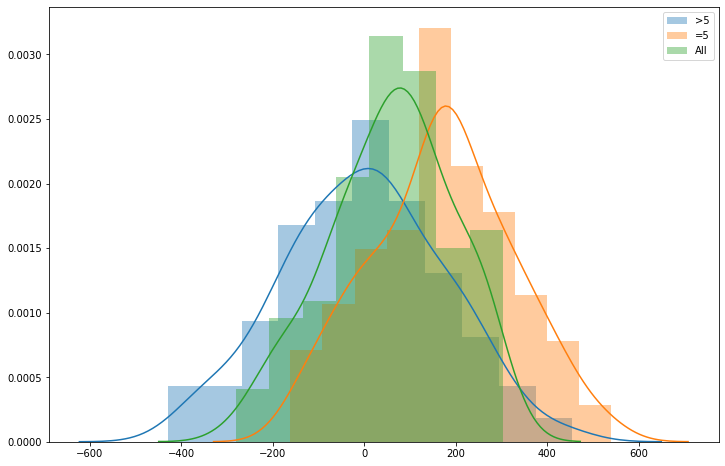

In [361]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(bigger5, label = '>5')
sns.distplot(equal5, label = '=5')
sns.distplot(C, label = 'All')
ax.legend()


In [1]:
fig, ax = plt.subplots(figsize=(12,8))

sns.kdeplot(bigger5_, label = '>5')
sns.kdeplot(equal5_, label = '=5')
sns.distplot(C_, label = 'All')
ax.legend()

NameError: name 'plt' is not defined

In [268]:
dict_aux_5.items()

In [349]:
list_values_5 = [v for v in dict_aux_5.values() ]
list_values_5[0]

{'idx': 19632,
 'timestamp': 1578312062110.0,
 'symbol': 'WDOG20',
 'side': 1,
 'price': 4063.0,
 'quantity': 1,
 'type': 'taker',
 'order_id': 14,
 'react_msg_seq_num': 28705.0,
 'qntd': 5.0}

In [350]:
list_values_20 = [ v for v in dict_aux_20.values() ]
list_values_20[0]

{'idx': 19075,
 'timestamp': 1578312061489.0,
 'symbol': 'WDOG20',
 'side': 1,
 'price': 4063.5,
 'quantity': 1,
 'type': 'taker',
 'order_id': 12,
 'react_msg_seq_num': 28296.0,
 'qntd': 10.0}

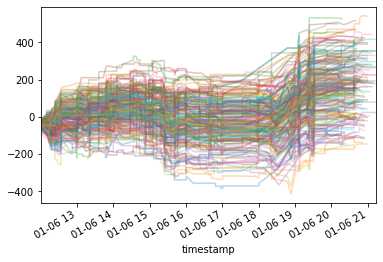

In [355]:
fig, ax = plt.subplots()
equal5 = []
equal5_ = []


for i in range(200):
    tds = fetch_with_fillrate(0.3,0.3,1, '2020-01-06', 'Taker', list_values_5,{'signal' : 'insert_wo_trades'})
    manager.trades_return(tds, adtv=200, hft=False)['WDOG20'].plot(ax=ax, alpha=0.3)  # Aplica os custos operacionais em um dos caminhos que tu criar
    equal5.append(manager.trades_return(tds, adtv=200, hft=False)['WDOG20'][-1])# Aplica os custos operacionais em um dos caminhos que tu criar
    equal5_.append(len(tds))# Aplica os custos operacionais em um dos caminhos que tu criar


In [356]:
np.mean(B)

175.29124699999596

In [358]:
np.mean(A)

18.887748999998088

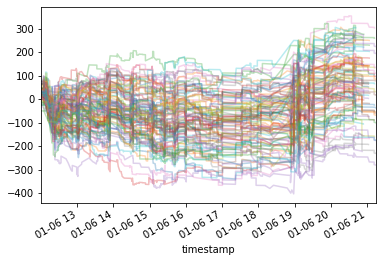

In [359]:
fig, ax = plt.subplots()

C =[]
C_ = []
for i in range(100):
    tds = manager.fetch_with_fillrate(0.3, 0.3, 1, '2020-01-06', 'Taker', {'signal' : 'insert_wo_trades'})
    manager.trades_return(tds, adtv=200, hft=False)['WDOG20'].plot(ax=ax, alpha=0.3)  # Aplica os custos operacionais em um dos caminhos que tu criar
    C.append(manager.trades_return(tds, adtv=200, hft=False)['WDOG20'][-1])# Aplica os custos operacionais em um dos caminhos que tu criar
    C_.append(len(tds))# Aplica os custos operacionais em um dos caminhos que tu criar


In [360]:
np.mean(C)

58.853163999990336

## Estudo dedicado Quantidade

In [11]:
manager = Manager()

[ Asynch ] STARTING THREAD. _run


In [67]:
date_ = "2020-01-06"

In [68]:
e = Causality("DOLG20", "WDOG20", date_)
df = e._files()
e.events['msg_seq_num'].duplicated().any() 
e.events['repeat'] = False
e.events['repeat'][e.events['msg_seq_num'] != e.events['msg_seq_num'].shift(-1)] = True
e.events  = e.events[e.events['repeat']]
insert_dol = e.events[e.events['event_type'] == 'INSERT']

md_trades, md_trades_wdo = get_trades("DOLG20", "WDOG20", date_)
all_trades =  pd.concat([md_trades,md_trades_wdo]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()
list_of_trades = all_trades.groupby('msg_seq_num').sum().index
insert_dol = insert_dol[~insert_dol['msg_seq_num'].isin(list_of_trades)].reset_index()


all_trades_monte_carlo = manager._get_all_possible_trades(date_, 'Taker', {'signal' : 'insert_wo_trades'})  

dict_map_qtd = insert_dol.set_index("msg_seq_num").to_dict()["quantity"]
df_all_trades = pd.DataFrame(all_trades_monte_carlo)
df_all_trades["qntd"] = df_all_trades["react_msg_seq_num"].map(dict_map_qtd)

dict_aux = df_all_trades.T.to_dict()

all_trades_qnt = []
for i in dict_aux.keys():
    all_trades_qnt.append(dict_aux[i])
    

/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/asimovws/.local/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

[ MANAGER ] Downloading results


In [3]:
#qntd_seacher(test= 'equal', all_trades_qnt = all_trades_qnt , number = 5):

def qntd_seacher(test, all_trades_qnt, number):
    dict_aux_ = {}
    j= 0
    for i in range(len(all_trades_qnt)):
        if test == 'equal': 
            if all_trades_qnt[i]['qntd'] == number:
                dict_aux_[j] = all_trades_qnt[i]
                j+=1
        else:
            if all_trades_qnt[i]['qntd'] >= number:
                dict_aux_[j] = all_trades_qnt[i]
                j+=1
    return dict_aux_

In [5]:
#monte_carlo(date = '2020-01-07' , files =dict_aux_)

def monte_carlo(date, files, symbol):

    fig, ax = plt.subplots()
    last_value = []
    size = []


    for i in range(100):
        tds = fetch_with_fillrate(0.3,0.3,1, date, 'Taker', files,{'signal' : 'insert_wo_trades'})
        manager.trades_return(tds, adtv=50, hft=False)[symbol].plot(ax=ax, alpha=0.3)  # Aplica os custos operacionais em um dos caminhos que tu criar
        last_value.append(manager.trades_return(tds, adtv=50, hft=False)[symbol][-1])# Aplica os custos operacionais em um dos caminhos que tu criar
        size.append(len(tds))# Aplica os custos operacionais em um dos caminhos que tu criar
        
    return last_value, size

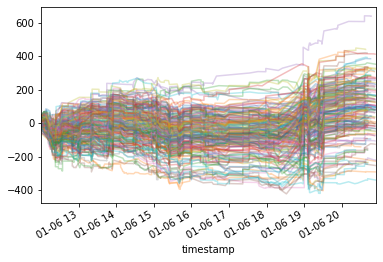

In [69]:
files = qntd_seacher(test= 'equal', all_trades_qnt = all_trades_qnt , number = 5)

equals5, equals5_size = monte_carlo(date = date_ , files =files, symbol = 'WDOG20')


/home/asimovws/.local/lib/python3.6/site-packages/asimov_strategy/fees/dol_fees.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['quantity'][df_trades['side'] == 1] *= -1
/home/asimovws/.local/lib/python3.6/site-packages/asimov_strategy/fees/dol_fees.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trades['quantity'][df_trades['side'] == 1] *= -1
/home/asimovws/.local/lib/python3.6/site-packages/asimov_strategy/fees/dol_fees.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

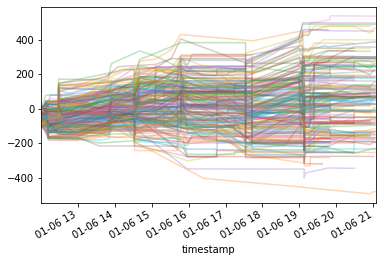

In [70]:
files = qntd_seacher(test= 'bigger', all_trades_qnt = all_trades_qnt , number = 20)

bigger_or_equal20, bigger_or_equal20_size = monte_carlo(date = date_ , files =files, symbol = 'WDOG20')

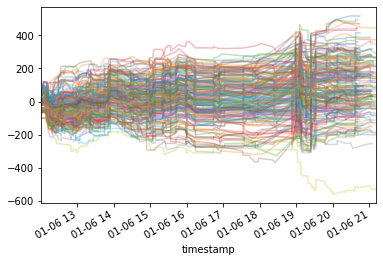

In [71]:
files = qntd_seacher(test= 'bigger', all_trades_qnt = all_trades_qnt , number = 6)

bigger5, bigger5_size = monte_carlo(date = date_ , files =files, symbol = 'WDOG20')

## Whole month (JAN & DEZ) analysis


In [6]:
DATE_JAN = [
 '2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2020-01-07',
 '2020-01-08',
 '2020-01-09', 
 '2020-01-10',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-20',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-27']

In [7]:
DATE_DEZ = ['2019-12-02',
 '2019-12-03',
 '2019-12-04',
 '2019-12-05',
 '2019-12-06',
 '2019-12-09',
 '2019-12-10',
 '2019-12-11',
 '2019-12-12',
 '2019-12-13',
 '2019-12-16',
 '2019-12-17',
 '2019-12-18',
 '2019-12-19',
 '2019-12-20',
 '2019-12-23',
 '2019-12-26',
 '2019-12-27', 
 '2019-12-30']


In [1]:
dict_distribution_dez = {}
dict_distribution_size_dez = {}

# dict_distribution_jan = {}
# dict_distribution_size_jan = {}

j= 0
DOL = 'DOLF20'
WDO = 'WDOF20'


for date_ in DATE_DEZ:
#     e = Causality("DOLG20", "WDOG20", date_)
    events = pr.get_parquet(DOL, date_, "events")["incremental"].read().to_pandas()
    events.reset_index(inplace=True)

#     df = e._files()
    events['msg_seq_num'].duplicated().any() 
    events['repeat'] = False
    events['repeat'][events['msg_seq_num'] != events['msg_seq_num'].shift(-1)] = True
    events  = events[events['repeat']]
    insert_dol = events[events['event_type'] == 'INSERT']

    md_trades, md_trades_wdo = get_trades(DOL, WDO, date_)
    all_trades =  pd.concat([md_trades,md_trades_wdo]).sort_values(by='msg_seq_num', kind = 'mergesort').reset_index()
    list_of_trades = all_trades.groupby('msg_seq_num').sum().index
    insert_dol = insert_dol[~insert_dol['msg_seq_num'].isin(list_of_trades)].reset_index()


    all_trades_monte_carlo = manager._get_all_possible_trades(date_, 'Taker', {'signal' : 'insert_wo_trades'})  

    dict_map_qtd = insert_dol.set_index("msg_seq_num").to_dict()["quantity"]
    df_all_trades = pd.DataFrame(all_trades_monte_carlo)
    df_all_trades["qntd"] = df_all_trades["react_msg_seq_num"].map(dict_map_qtd)

    dict_aux = df_all_trades.T.to_dict()

    all_trades_qnt = []
    for i in dict_aux.keys():
        all_trades_qnt.append(dict_aux[i])


    files = qntd_seacher(test= 'equal', all_trades_qnt = all_trades_qnt , number = 5)
    equals5, equals5_size = monte_carlo(date = date_ , files =files, symbol = WDO)
    files = qntd_seacher(test= 'bigger', all_trades_qnt = all_trades_qnt , number = 5)
    bigger5, bigger5_size = monte_carlo(date = date_ , files =files, symbol = WDO)
    
    dict_distribution_dez[j] = pd.DataFrame([equals5, bigger5])
    dict_distribution_size_dez[j] = pd.DataFrame([equals5_size, bigger5_size])

#     dict_distribution_jan[j] = pd.DataFrame([equals5, bigger5])
#     dict_distribution_size_jan[j] = pd.DataFrame([equals5_size, bigger5_size])
    
    j+=1

    

NameError: name 'DATE_DEZ' is not defined

In [40]:
date_

'2019-11-07'

In [26]:
def plot_dist():
    fig, ax = plt.subplots(figsize=(12,8))

    sns.distplot(bigger5, label = '>5')
    sns.distplot(equals5, label = '=5')
    sns.distplot(bigger_or_equal20, label = '>=20')

    # sns.distplot(C_, label = 'All')
    ax.legend()

## Day-to-day distribution

### Dia 02/01

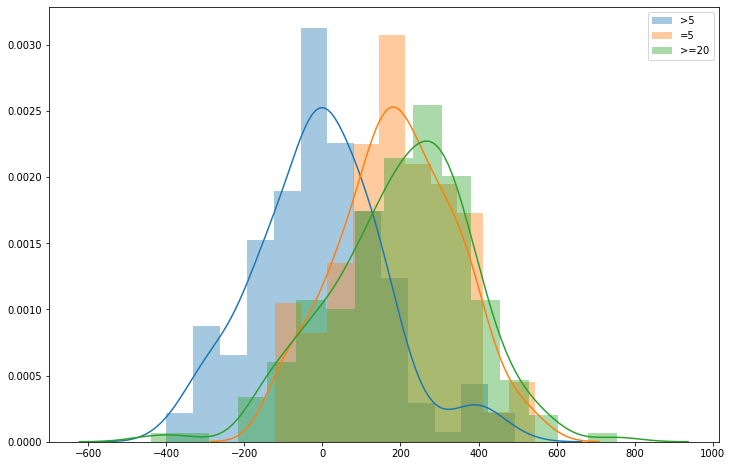

In [291]:
plot_dist()


### Dia 03/01

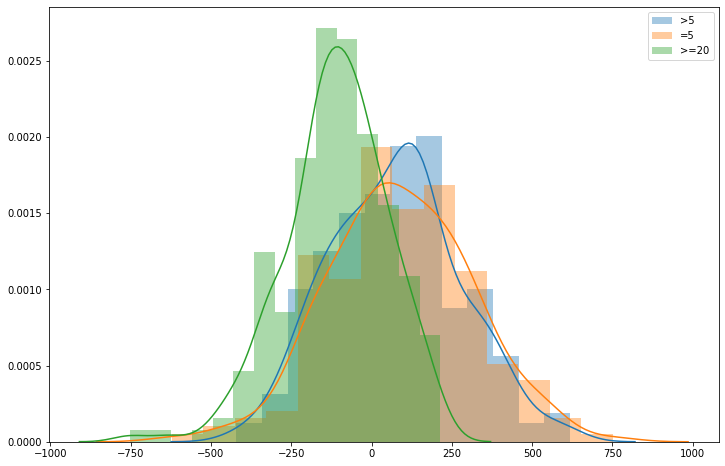

In [298]:
plot_dist()


### Dia 06/01

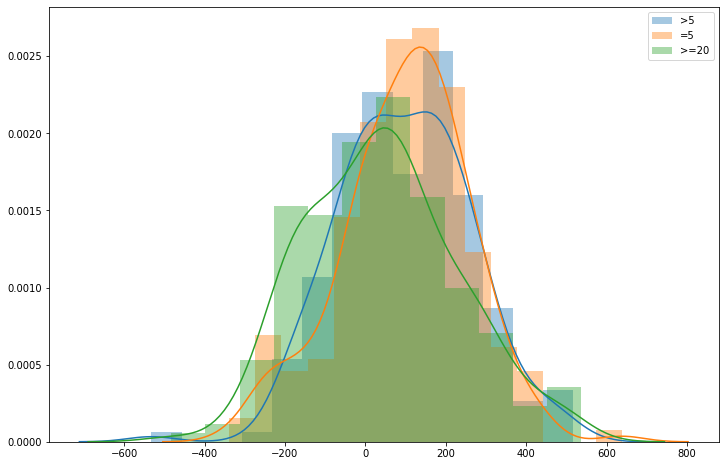

In [72]:
plot_dist()


### Dia 07/01 

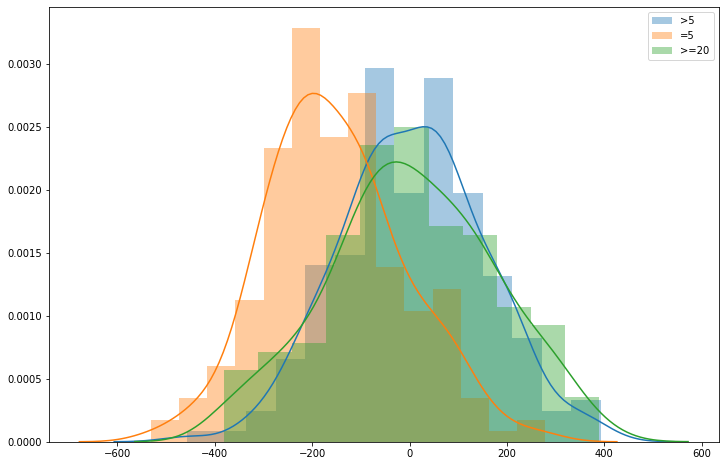

In [312]:
plot_dist()


### Dia 08/01 

In [ ]:
plot_dist()


### Dia 09/01

In [ ]:
plot_dist()


### Dia 10/01

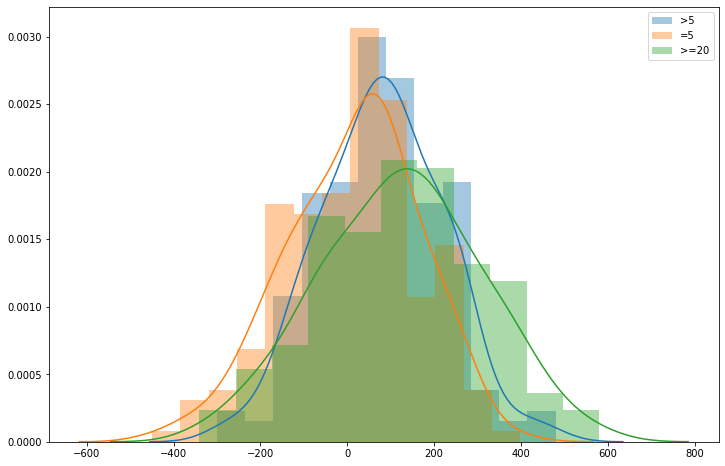

In [41]:
plot_dist()

### Dia 13/01

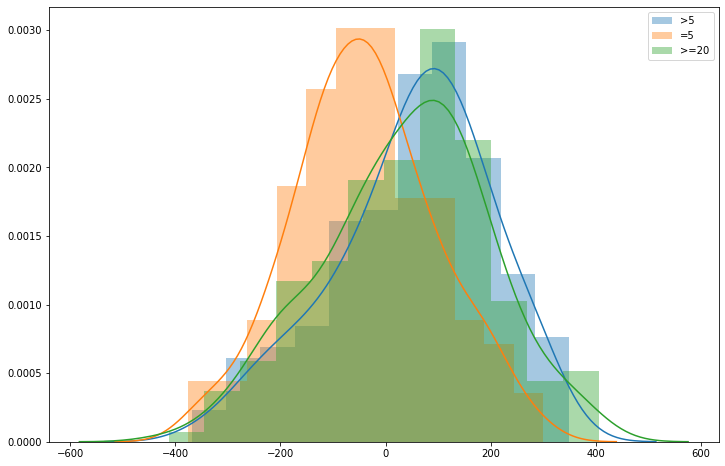

In [47]:
plot_dist()

### Dia 16/01

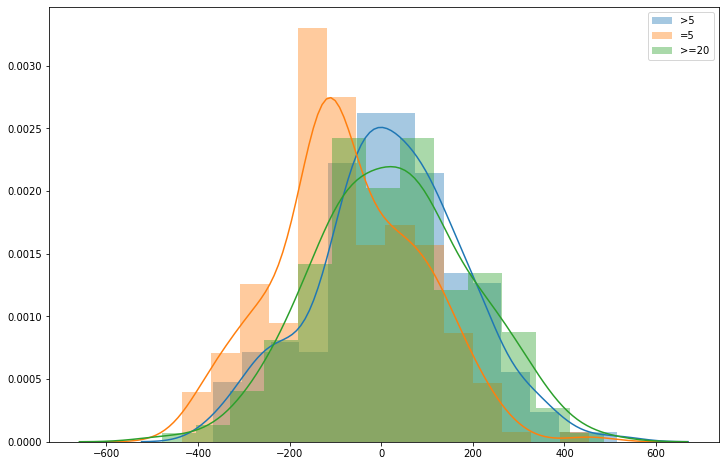

In [53]:
plot_dist()

# Teste estatistico de comparacao de dist

In [18]:
from scipy import stats
from scipy.stats import ks_2samp


# ALL DAYS

## JAN/20

In [35]:
# Filtra as distribuiçõe equivalentes

dict_stats = {}
for i in dict_distribution_jan.keys():
    if ks_2samp(dict_distribution_jan[i].values[0],dict_distribution_jan[i].values[1])[1] < 0.05:
        dict_stats[i] = ks_2samp(dict_distribution_jan[i].values[0],dict_distribution_jan[i].values[1])

In [44]:
Mean5 = []
Mean_b_5 = []
for j in dict_stats.keys():
    Mean5.append(np.mean(dict_distribution_jan[j].values[0]))
    Mean_b_5.append(np.mean(dict_distribution_jan[j].values[1]))

    
    

In [38]:
Mean5_size = []
Mean_b_5_size = []
for j in dict_stats.keys():
    Mean5_size.append(np.mean(dict_distribution_size_jan[j].values[0]))
    Mean_b_5_size.append(np.mean(dict_distribution_size_jan[j].values[1]))

### Como as médias se comportam ?

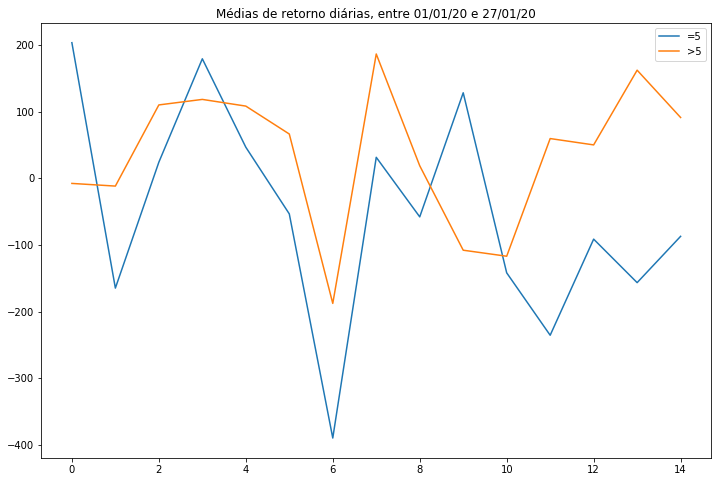

In [239]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(Mean5, label = '=5')
plt.plot(Mean_b_5,label = '>5')

ax.set_title('Médias de retorno diárias, entre 01/01/20 e 27/01/20')


ax.legend()


### Distribuição das médias

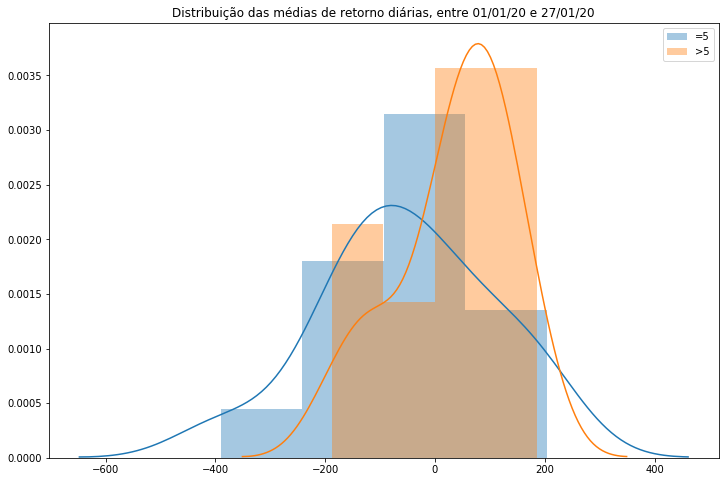

In [240]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5')
sns.distplot(Mean_b_5, label = '>5')


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

In [ ]:
# print('Média das médias para INSERT = 5: {} , Média das médias para INSERT > 5: {}'.format(np.mean(Mean5),np.mean(Mean_b_5)))

### Distribuição das quantidades de trades realizados

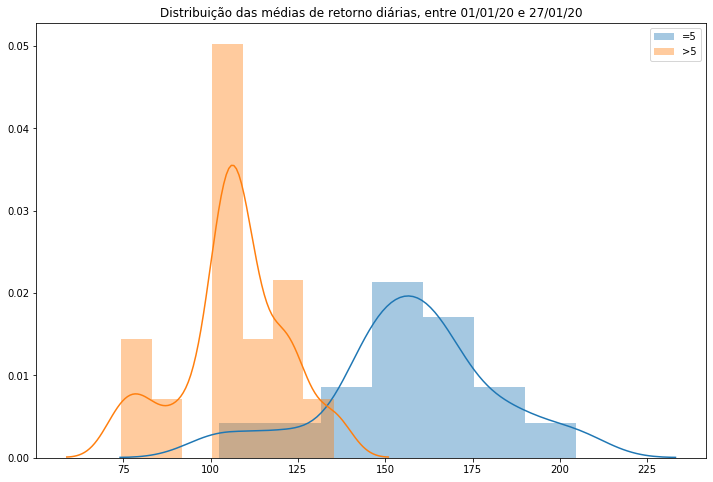

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5_size, label = '=5')
sns.distplot(Mean_b_5_size, label = '>5')


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

In [46]:
print('Média das médias para INSERT = 5: {} , Média das médias para INSERT > 5: {}'.format(np.mean(Mean5_size),np.mean(Mean_b_5_size)))

Média das médias para INSERT = 5: 157.2375 , Média das médias para INSERT > 5: 106.664375


## DEZ/19

In [19]:
dict_stats = {}
for i in dict_distribution_dez.keys():
    if ks_2samp(dict_distribution_dez[i].values[0],dict_distribution_dez[i].values[1])[1] < 0.05:
        dict_stats[i] = ks_2samp(dict_distribution_dez[i].values[0],dict_distribution_dez[i].values[1])

In [20]:
Mean5 = []
Mean_b_5 = []
for j in dict_stats.keys():
    Mean5.append(np.mean(dict_distribution_dez[j].values[0]))
    Mean_b_5.append(np.mean(dict_distribution_dez[j].values[1]))

In [21]:
Mean5_size = []
Mean_b_5_size = []
for j in dict_stats.keys():
    Mean5_size.append(np.mean(dict_distribution_size_dez[j].values[0]))
    Mean_b_5_size.append(np.mean(dict_distribution_size_dez[j].values[1]))

### Como se comportam as médias?

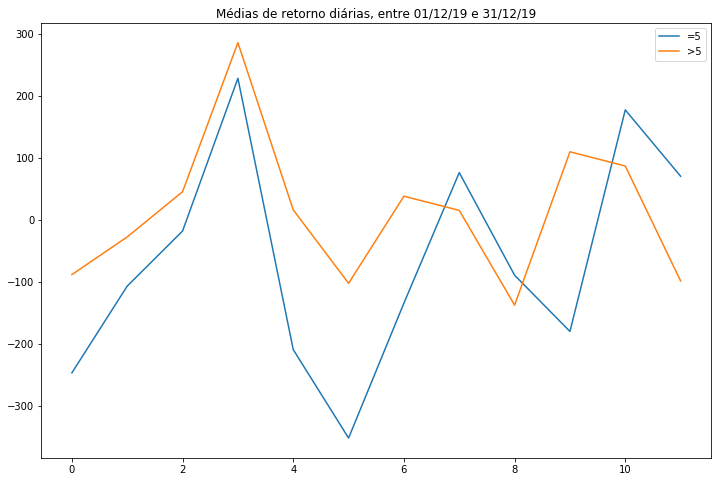

In [245]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(Mean5, label = '=5')
plt.plot(Mean_b_5,label = '>5')

ax.set_title('Médias de retorno diárias, entre 01/12/19 e 31/12/19')


ax.legend()


### Distribuição das médias

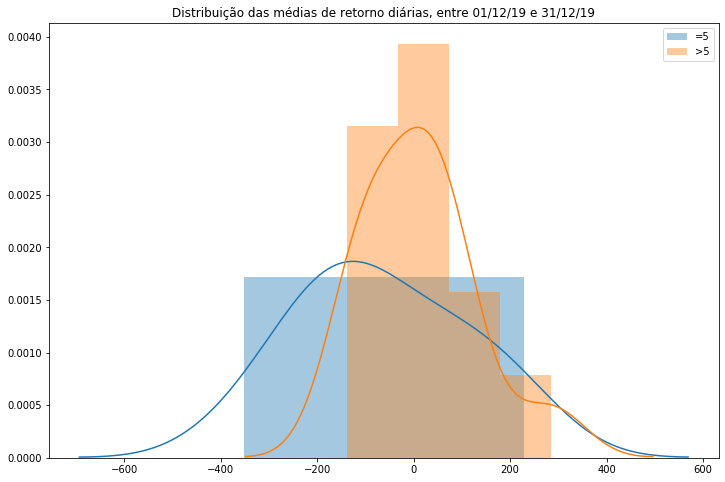

In [246]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5, label = '=5')
sns.distplot(Mean_b_5, label = '>5')

ax.set_title('Distribuição das médias de retorno diárias, entre 01/12/19 e 31/12/19')



# sns.distplot(C_, label = 'All')
ax.legend()

In [ ]:
# print('Média das médias para INSERT = 5: {} , Média das médias para INSERT > 5: {}'.format(np.mean(Mean5),np.mean(Mean_b_5)))

### Distribuição das quantidades de trades

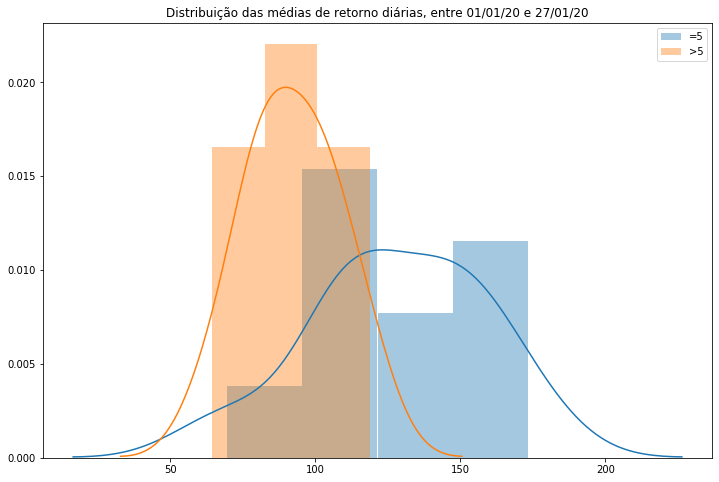

In [59]:
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(Mean5_size, label = '=5')
sns.distplot(Mean_b_5_size, label = '>5')


ax.set_title('Distribuição das médias de retorno diárias, entre 01/01/20 e 27/01/20')
# sns.distplot(C_, label = 'All')
ax.legend()

In [60]:
print('Média das médias para INSERT = 5: {} , Média das médias para INSERT > 5: {}'.format(np.mean(Mean5_size),np.mean(Mean_b_5_size)))

Média das médias para INSERT = 5: 128.24900000000002 , Média das médias para INSERT > 5: 91.989
